# USA Water Systems and Operators

## References

|Link|Notes|
|---|---|
|https://www.bls.gov/cew/downloadable-data-files.htm|County-level labor statistics|


## Imports and Setup

In [481]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from fuzzywuzzy import fuzz, process
from mpl_toolkits.axes_grid1 import make_axes_locatable
import fiona as fiona
from ipypb import track

In [46]:
pd.options.display.max_columns = 999

## Data

In [476]:
folder_WaterSystems = "C:\\Users\\garfink2\\Documents\\data\\drinkingwater\\watersystems"
csv_FacilityFiles = "C:\\Users\\garfink2\\Documents\\data\\drinkingwater\\national_combined\\NATIONAL_FACILITY_FILE.CSV"
shp_USCounties = "C:\\Users\\garfink2\\Documents\\data\\basemap\\tl_2017_us_county\\tl_2017_us_county.shp"
excel_StateFPCodes = "C:\\Users\\garfink2\\Documents\\data\\basemap\\statefpcodes.xlsx"
excel_BLSIndustries = "C:\\Users\\garfink2\\Documents\\data\\bls\\Copy of industry_titles.xlsx"
csv_EmployementData2019Q1 = "C:\\Users\\garfink2\\Documents\\data\\bls\\2019_qtrly_singlefile\\2019.q1-q3.singlefile.csv"
csv_EmploymentData2018 = "C:\\Users\\garfink2\\Documents\\data\\bls\\2018_annual_singlefile\\2018.annual.singlefile.csv"
gdbPath = r"C:\Users\garfink2\Documents\data\infrastructure\ArmyWide_CIP_Repository_Extract_SDSFIE_4_0_2_20191209.gdb"

## Analyses

### Water Treatment Systems

In [6]:
list_StateFiles = os.listdir(folder_WaterSystems)

In [12]:
dict_StateFiles = {}
for stateFile in list_StateFiles:
    df = pd.read_csv(f"{folder_WaterSystems}/{stateFile}",encoding='cp1252')
    df["State"] = stateFile.split('.')[0].upper()
    dict_StateFiles[stateFile.split('.')[0].upper()] = df

In [31]:
df_AllStateWaterSupplies = pd.concat(list(dict_StateFiles.values()))

### National Facilities

In [22]:
nationalFacilities = pd.read_csv(csv_FacilityFiles)

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (4,7,11,12,13,14,15,16,21,23,24,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
nationalFacilities.head()

FRS_FACILITY_DETAIL_REPORT_URL   REGISTRY_ID  \
0  http://ofmpub.epa.gov/enviro/fii_query_detail....  110000491735   
1  http://ofmpub.epa.gov/enviro/fii_query_detail....  110000491744   
2  http://ofmpub.epa.gov/enviro/fii_query_detail....  110000491762   
3  http://ofmpub.epa.gov/enviro/fii_query_detail....  110000491780   
4  http://ofmpub.epa.gov/enviro/fii_query_detail....  110000491824   

                                    PRIMARY_NAME            LOCATION_ADDRESS  \
0  OCEAN DOCK TERMINAL AND ANCHORAGE TERMINAL II          1076 OCEAN DOCK RD   
1                     INLET PERTROLEUM ANCHORAGE              459 W BLUFF DR   
2                                     UNIVAR USA             590 E 100TH AVE   
3                   FAIRBANKS PETROLEUM TERMINAL  5500 AIRPORT INDUSTRIAL RD   
4               TESORO ALASKA KETCHIKAN TERMINAL             1010 STEDMAN ST   

  SUPPLEMENTAL_LOCATION  CITY_NAME           COUNTY_NAME FIPS_CODE STATE_CODE  \
0                   NaN  ANCHORAGE             ANCHORAGE     02020         AK   
1                   NaN  ANCHORAGE             ANCHORAGE     02020         AK   
2                   NaN  ANCHORAGE             ANCHORAGE     02020         AK   
3                   NaN  FAIRBANKS  FAIRBANKS NORTH STAR     02090         AK   
4                   NaN  KETCHIKAN     KETCHIKAN GATEWAY     02130         AK   

  STATE_NAME  ... US_MEXICO_BORDER_IND  \
0     ALASKA  ...                  NaN   
1     ALASKA  ...                  NaN   
2     ALASKA  ...                  NaN   
3     ALASKA  ...                  NaN   
4     ALASKA  ...                  NaN   

                                      PGM_SYS_ACRNMS LATITUDE83 LONGITUDE83  \
0  AIR:AK0000000202000032, AIRS/AFS:0202000032, B...  61.229579 -149.893094   
1  EIS:677611, ICIS:2600029860, ICIS:5870869, NPD...  61.231236 -149.888143   
2  AIR:AK0000000202000105, BR:AKD981765902, EIS:6...  61.129407 -149.871824   
3  EIS:680011, ICIS:600007563, NPDES:AKR06AB58, N...  64.811292 -147.884914   
4  EIS:540611, NPDES:AK0000523, RCRAINFO:AKD09983...  55.335010 -131.627950   

   CONVEYOR                   COLLECT_DESC ACCURACY_VALUE  \
0   EPA_SLT            INTERPOLATION-PHOTO          125.0   
1   EPA_SLT            INTERPOLATION-PHOTO            3.0   
2   EPA_SLT            INTERPOLATION-PHOTO            3.0   
3   EPA_SLT            INTERPOLATION-PHOTO            3.0   
4  FRS-TRIS  ADDRESS MATCHING-HOUSE NUMBER           30.0   

                    REF_POINT_DESC  HDATUM_DESC  SOURCE_DESC  
0                FACILITY CENTROID        NAD83          NaN  
1                FACILITY CENTROID        NAD83          NaN  
2                FACILITY CENTROID        NAD83          NaN  
3                FACILITY CENTROID        NAD83          NaN  
4  CENTER OF A FACILITY OR STATION        NAD83          NaN  

[5 rows x 34 columns]

In [24]:
nationalFacilities.columns

Index(['FRS_FACILITY_DETAIL_REPORT_URL', 'REGISTRY_ID', 'PRIMARY_NAME',
       'LOCATION_ADDRESS', 'SUPPLEMENTAL_LOCATION', 'CITY_NAME', 'COUNTY_NAME',
       'FIPS_CODE', 'STATE_CODE', 'STATE_NAME', 'COUNTRY_NAME', 'POSTAL_CODE',
       'FEDERAL_FACILITY_CODE', 'FEDERAL_AGENCY_NAME', 'TRIBAL_LAND_CODE',
       'TRIBAL_LAND_NAME', 'CONGRESSIONAL_DIST_NUM', 'CENSUS_BLOCK_CODE',
       'HUC_CODE', 'EPA_REGION_CODE', 'SITE_TYPE_NAME', 'LOCATION_DESCRIPTION',
       'CREATE_DATE', 'UPDATE_DATE', 'US_MEXICO_BORDER_IND', 'PGM_SYS_ACRNMS',
       'LATITUDE83', 'LONGITUDE83', 'CONVEYOR', 'COLLECT_DESC',
       'ACCURACY_VALUE', 'REF_POINT_DESC', 'HDATUM_DESC', 'SOURCE_DESC'],
      dtype='object')

In [25]:
nationalFacilities["FRS_FACILITY_DETAIL_REPORT_URL"][1]

'http://ofmpub.epa.gov/enviro/fii_query_detail.disp_program_facility?p_registry_id=110000491744'

In [26]:
nationalFacilities["HUC_CODE"]

0          19020401.0
1          19020401.0
2          19020401.0
3          19040506.0
4          19010102.0
              ...    
4224068           NaN
4224069           NaN
4224070           NaN
4224071           NaN
4224072           NaN
Name: HUC_CODE, Length: 4224073, dtype: float64

### Basemap Data

In [28]:
gdf_USCounties = gpd.read_file(shp_USCounties)

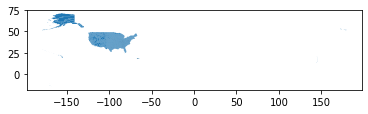

In [29]:
gdf_USCounties.plot()

In [30]:
gdf_USCounties.head()

STATEFP COUNTYFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD CLASSFP  \
0      31      039  00835841  31039     Cuming     Cuming County   06      H1   
1      53      069  01513275  53069  Wahkiakum  Wahkiakum County   06      H1   
2      35      011  00933054  35011    De Baca    De Baca County   06      H1   
3      31      109  00835876  31109  Lancaster  Lancaster County   06      H1   
4      31      129  00835886  31129   Nuckolls   Nuckolls County   06      H1   

   MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND    AWATER     INTPTLAT  \
0  G4020  None   None     None        A  1477641638  10701538  +41.9158651   
1  G4020  None   None     None        A   680956787  61588406  +46.2946377   
2  G4020  None   None     None        A  6016761648  29147345  +34.3592729   
3  G4020   339  30700     None        A  2169252486  22867561  +40.7835474   
4  G4020  None   None     None        A  1489645186   1718484  +40.1764918   

       INTPTLON                                           geometry  
0  -096.7885168  POLYGON ((-97.01952 42.00410, -97.01952 42.004...  
1  -123.4244583  POLYGON ((-123.43639 46.23820, -123.44759 46.2...  
2  -104.3686961  POLYGON ((-104.56739 33.99757, -104.56772 33.9...  
3  -096.6886584  POLYGON ((-96.91060 40.95841, -96.91060 40.958...  
4  -098.0468422  POLYGON ((-98.27367 40.08940, -98.27367 40.089...

Overlay locations of Army Installations

In [477]:
def readGDB(gdbPath,layersToRead=None):
    dfs = {}
    if not layersToRead:
        layers = fiona.listlayers(gdbPath)
    else:
        layers = layersToRead
    nFailed = 0
    for l in track(layers):
        try:
            df = gpd.read_file(gdbPath, driver='FileGDB', layer=l)
            dfs[l] = df
        except:
            dfs[l] = "FAILED"
            nFailed += 1
            print(f"Layer: {l} FAILED")
    print(f"Processed {len(layers)} layers, with {nFailed} failures.")
    return dfs

In [479]:
layersToRead = ['Installation_A']

In [482]:
dict_installations = readGDB(gdbPath,layersToRead=layersToRead)

 [████████████████████████████████████████████████████████████] 1/1 [00:00<00:00, 0.22s/it]

Processed 1 layers, with 0 failures.


In [487]:
installationAreas = dict_installations["Installation_A"]

Reproject

In [492]:
installationAreas = installationAreas.to_crs(gdf_USCounties.crs['init'])

### Map water systems to US counties

In [34]:
df_StateFPCodes = pd.read_excel(excel_StateFPCodes)

In [62]:
df_StateFPCodes

Name Postal Code  FIPS
0                    Alabama          AL     1
1                     Alaska          AK     2
2                    Arizona          AZ     4
3                   Arkansas          AR     5
4                 California          CA     6
5                   Colorado          CO     8
6                Connecticut          CT     9
7                   Delaware          DE    10
8                    Florida          FL    12
9                    Georgia          GA    13
10                    Hawaii          HI    15
11                     Idaho          ID    16
12                  Illinois          IL    17
13                   Indiana          IN    18
14                      Iowa          IA    19
15                    Kansas          KS    20
16                  Kentucky          KY    21
17                 Louisiana          LA    22
18                     Maine          ME    23
19                  Maryland          MD    24
20             Massachusetts          MA    25
21                  Michigan          MI    26
22                 Minnesota          MN    27
23               Mississippi          MS    28
24                  Missouri          MO    29
25                   Montana          MT    30
26                  Nebraska          NE    31
27                    Nevada          NV    32
28             New Hampshire          NH    33
29                New Jersey          NJ    34
30                New Mexico          NM    35
31                  New York          NY    36
32            North Carolina          NC    37
33              North Dakota          ND    38
34                      Ohio          OH    39
35                  Oklahoma          OK    40
36                    Oregon          OR    41
37              Pennsylvania          PA    42
38              Rhode Island          RI    44
39            South Carolina          SC    45
40              South Dakota          SD    46
41                 Tennessee          TN    47
42                     Texas          TX    48
43                      Utah          UT    49
44                   Vermont          VT    50
45                  Virginia          VA    51
46                Washington          WA    53
47             West Virginia          WV    54
48                 Wisconsin          WI    55
49                   Wyoming          WY    56
50            American Samoa          AS    60
51                      Guam          GU    66
52  Northern Mariana Islands          MP    69
53               Puerto Rico          PR    72
54            Virgin Islands          VI    78

In [38]:
df_AllStateWaterSupplies = pd.merge(left=df_AllStateWaterSupplies,right=df_StateFPCodes,left_on="State",right_on="Postal Code")

In [39]:
df_AllStateWaterSupplies

PWS ID                            PWS Name  \
0       AK2260595                      ADAK UTILITIES   
1       AK2250037                              AKHIOK   
2       AK2272747               AKIACHAK WATER SYSTEM   
3       AK2272005        AKIAK COMMUNITY WATER SYSTEM   
4       AK2260252                              AKUTAN   
...           ...                                 ...   
143884  WY5680086      YELLOWSTONE NP-PEBBLE CREEK CG   
143885  WY5680152      YELLOWSTONE NP-SLOUGH CREEK CG   
143886  WY5680089        YELLOWSTONE NP-TOWER FALL CG   
143887  WY5600471              YELLOWSTONE VALLEY INN   
143888  WY5600641  YMCA OF THE BIG HORNS CAMP ROBERTS   

                              PWS Type Primary Source  \
0               Community water system  Surface water   
1               Community water system  Surface water   
2               Community water system   Ground water   
3               Community water system   Ground water   
4               Community water system  Surface water   
...                                ...            ...   
143884  Transient non-community system   Ground water   
143885  Transient non-community system   Ground water   
143886  Transient non-community system   Ground water   
143887  Transient non-community system   Ground water   
143888  Transient non-community system   Ground water   

                   Counties Served   Cities Served PopulationServed Count  \
0       Aleutians West Census Area            ADAK                    325   
1            Kodiak Island Borough          AKHIOK                     90   
2               Bethel Census Area        AKIACHAK                    627   
3               Bethel Census Area           AKIAK                    346   
4           Aleutians East Borough          AKUTAN                     95   
...                            ...             ...                    ...   
143884                        Park  YELLOWSTONE NP                    100   
143885                        Park  YELLOWSTONE NP                     94   
143886                        Park  YELLOWSTONE NP                    495   
143887                        Park            CODY                    315   
143888                     Johnson         BUFFALO                     60   

        Number of Facilities  Number of Violations  Number of Site Visits  \
0                          9                   513                     10   
1                          6                  1175                      8   
2                          6                   147                      4   
3                          6                   489                      4   
4                          6                   572                      8   
...                      ...                   ...                    ...   
143884                    10                     3                      9   
143885                    10                     4                      7   
143886                     6                     1                      9   
143887                     6                    23                      7   
143888                    15                    47                     13   

       State     Name Postal Code  FIPS  
0         AK   Alaska          AK     2  
1         AK   Alaska          AK     2  
2         AK   Alaska          AK     2  
3         AK   Alaska          AK     2  
4         AK   Alaska          AK     2  
...      ...      ...         ...   ...  
143884    WY  Wyoming          WY    56  
143885    WY  Wyoming          WY    56  
143886    WY  Wyoming          WY    56  
143887    WY  Wyoming          WY    56  
143888    WY  Wyoming          WY    56  

[143889 rows x 14 columns]

Kludge- make the decision to assign water systems to the first county in their list so that I'm not multiple-counting staffing

In [49]:
nCountiesServed = {}
list_NCountiesServed = []
list_FirstCountiesServed = []
for i,row in df_AllStateWaterSupplies.iterrows():
    counties = row["Counties Served"].split(",")
    nCounties = len(counties)
    list_NCountiesServed.append(nCounties)
    list_FirstCountiesServed.append(counties[0])
    if nCounties in nCountiesServed.keys():
        nCountiesServed[nCounties] += 1
    else:
        nCountiesServed[nCounties] = 1
df_AllStateWaterSupplies["Number of Counties Served"] = list_NCountiesServed
df_AllStateWaterSupplies["First County Served"] = list_FirstCountiesServed

In [45]:
nCountiesServed

{1: 143738, 2: 97, 3: 32, 6: 2, 4: 10, 8: 3, 5: 3, 7: 3, 10: 1}

In [50]:
df_AllStateWaterSupplies[df_AllStateWaterSupplies["Number of Counties Served"] == 10]

PWS ID                           PWS Name                PWS Type  \
113166  SD4601089  WEB WATER DEVELOPMENT ASSOCIATION  Community water system   

       Primary Source                                    Counties Served  \
113166  Surface water  Brown, Campbell, Day, Edmunds, Faulk, Marshall...   

           Cities Served PopulationServed Count  Number of Facilities  \
113166  ABERDEEN, EUREKA                 16,568                    32   

        Number of Violations  Number of Site Visits State          Name  \
113166                     4                      8    SD  South Dakota   

       Postal Code  FIPS  Number of Counties Served First County Served  
113166          SD    46                         10               Brown

In [102]:
df_AllStateWaterSupplies["County FIPS"] = None
for stateFP in gdf_USCounties["STATEFP"].unique():
    gdf_StateCounties = gdf_USCounties[gdf_USCounties["STATEFP"]==stateFP]
    df_WaterSuppliesSubset = df_AllStateWaterSupplies[df_AllStateWaterSupplies["FIPS"]==int(stateFP)]
    for i,row in df_WaterSuppliesSubset.iterrows():
        county = row["First County Served"]
        # find the best match of county name
        bestMatch = process.extract(county,gdf_StateCounties.NAME,limit=5)[0][0]
        countyRow = gdf_StateCounties[gdf_StateCounties["NAME"] == bestMatch].iloc[0]
        countyFIPS = countyRow["GEOID"]
        df_AllStateWaterSupplies.at[i,'County FIPS'] = countyFIPS

In [103]:
df_AllStateWaterSupplies

PWS ID                            PWS Name  \
0       AK2260595                      ADAK UTILITIES   
1       AK2250037                              AKHIOK   
2       AK2272747               AKIACHAK WATER SYSTEM   
3       AK2272005        AKIAK COMMUNITY WATER SYSTEM   
4       AK2260252                              AKUTAN   
...           ...                                 ...   
143884  WY5680086      YELLOWSTONE NP-PEBBLE CREEK CG   
143885  WY5680152      YELLOWSTONE NP-SLOUGH CREEK CG   
143886  WY5680089        YELLOWSTONE NP-TOWER FALL CG   
143887  WY5600471              YELLOWSTONE VALLEY INN   
143888  WY5600641  YMCA OF THE BIG HORNS CAMP ROBERTS   

                              PWS Type Primary Source  \
0               Community water system  Surface water   
1               Community water system  Surface water   
2               Community water system   Ground water   
3               Community water system   Ground water   
4               Community water system  Surface water   
...                                ...            ...   
143884  Transient non-community system   Ground water   
143885  Transient non-community system   Ground water   
143886  Transient non-community system   Ground water   
143887  Transient non-community system   Ground water   
143888  Transient non-community system   Ground water   

                   Counties Served   Cities Served PopulationServed Count  \
0       Aleutians West Census Area            ADAK                    325   
1            Kodiak Island Borough          AKHIOK                     90   
2               Bethel Census Area        AKIACHAK                    627   
3               Bethel Census Area           AKIAK                    346   
4           Aleutians East Borough          AKUTAN                     95   
...                            ...             ...                    ...   
143884                        Park  YELLOWSTONE NP                    100   
143885                        Park  YELLOWSTONE NP                     94   
143886                        Park  YELLOWSTONE NP                    495   
143887                        Park            CODY                    315   
143888                     Johnson         BUFFALO                     60   

        Number of Facilities  Number of Violations  Number of Site Visits  \
0                          9                   513                     10   
1                          6                  1175                      8   
2                          6                   147                      4   
3                          6                   489                      4   
4                          6                   572                      8   
...                      ...                   ...                    ...   
143884                    10                     3                      9   
143885                    10                     4                      7   
143886                     6                     1                      9   
143887                     6                    23                      7   
143888                    15                    47                     13   

       State     Name Postal Code  FIPS  Number of Counties Served  \
0         AK   Alaska          AK     2                          1   
1         AK   Alaska          AK     2                          1   
2         AK   Alaska          AK     2                          1   
3         AK   Alaska          AK     2                          1   
4         AK   Alaska          AK     2                          1   
...      ...      ...         ...   ...                        ...   
143884    WY  Wyoming          WY    56                          1   
143885    WY  Wyoming          WY    56                          1   
143886    WY  Wyoming          WY    56                          1   
143887    WY  Wyoming          WY    56                          1   
143888    WY  Wyoming

Create county water supply summary

In [128]:
df_AllStateWaterSupplies["PopulationServed Count"] = df_AllStateWaterSupplies["PopulationServed Count"].str.replace(",","").astype("int")

In [134]:
numberWaterSuppliesInCounty = df_AllStateWaterSupplies.groupby("County FIPS").count()["PWS ID"]

In [135]:
numberWaterSuppliesInCounty

County FIPS
01001      7
01003     25
01005     10
01007      5
01009     12
        ... 
56037     46
56039    114
56041     12
56043      9
56045     13
Name: PWS ID, Length: 3087, dtype: int64

In [138]:
populationServedByCounty = df_AllStateWaterSupplies.groupby("County FIPS").sum()["PopulationServed Count"]

In [144]:
populationServedByCounty

County FIPS
01001     62988
01003    186590
01005     37356
01007     23541
01009     67126
          ...  
56037     54215
56039     55217
56041     19895
56043      7283
56045      6580
Name: PopulationServed Count, Length: 3087, dtype: int32

In [409]:
gdf_USCountyWaterSupplies = pd.merge(left=gdf_USCounties,right=populationServedByCounty,left_on="GEOID",right_on=populationServedByCounty.index)

In [410]:
gdf_USCountyWaterSupplies = pd.merge(left=gdf_USCountyWaterSupplies,right=numberWaterSuppliesInCounty,left_on="GEOID",right_on=numberWaterSuppliesInCounty.index)

In [411]:
gdf_USCountyWaterSupplies["County FIPS INT"] = gdf_USCountyWaterSupplies["GEOID"].astype("int")

Text(0.5, 1, 'CONUS water supplies by population served')

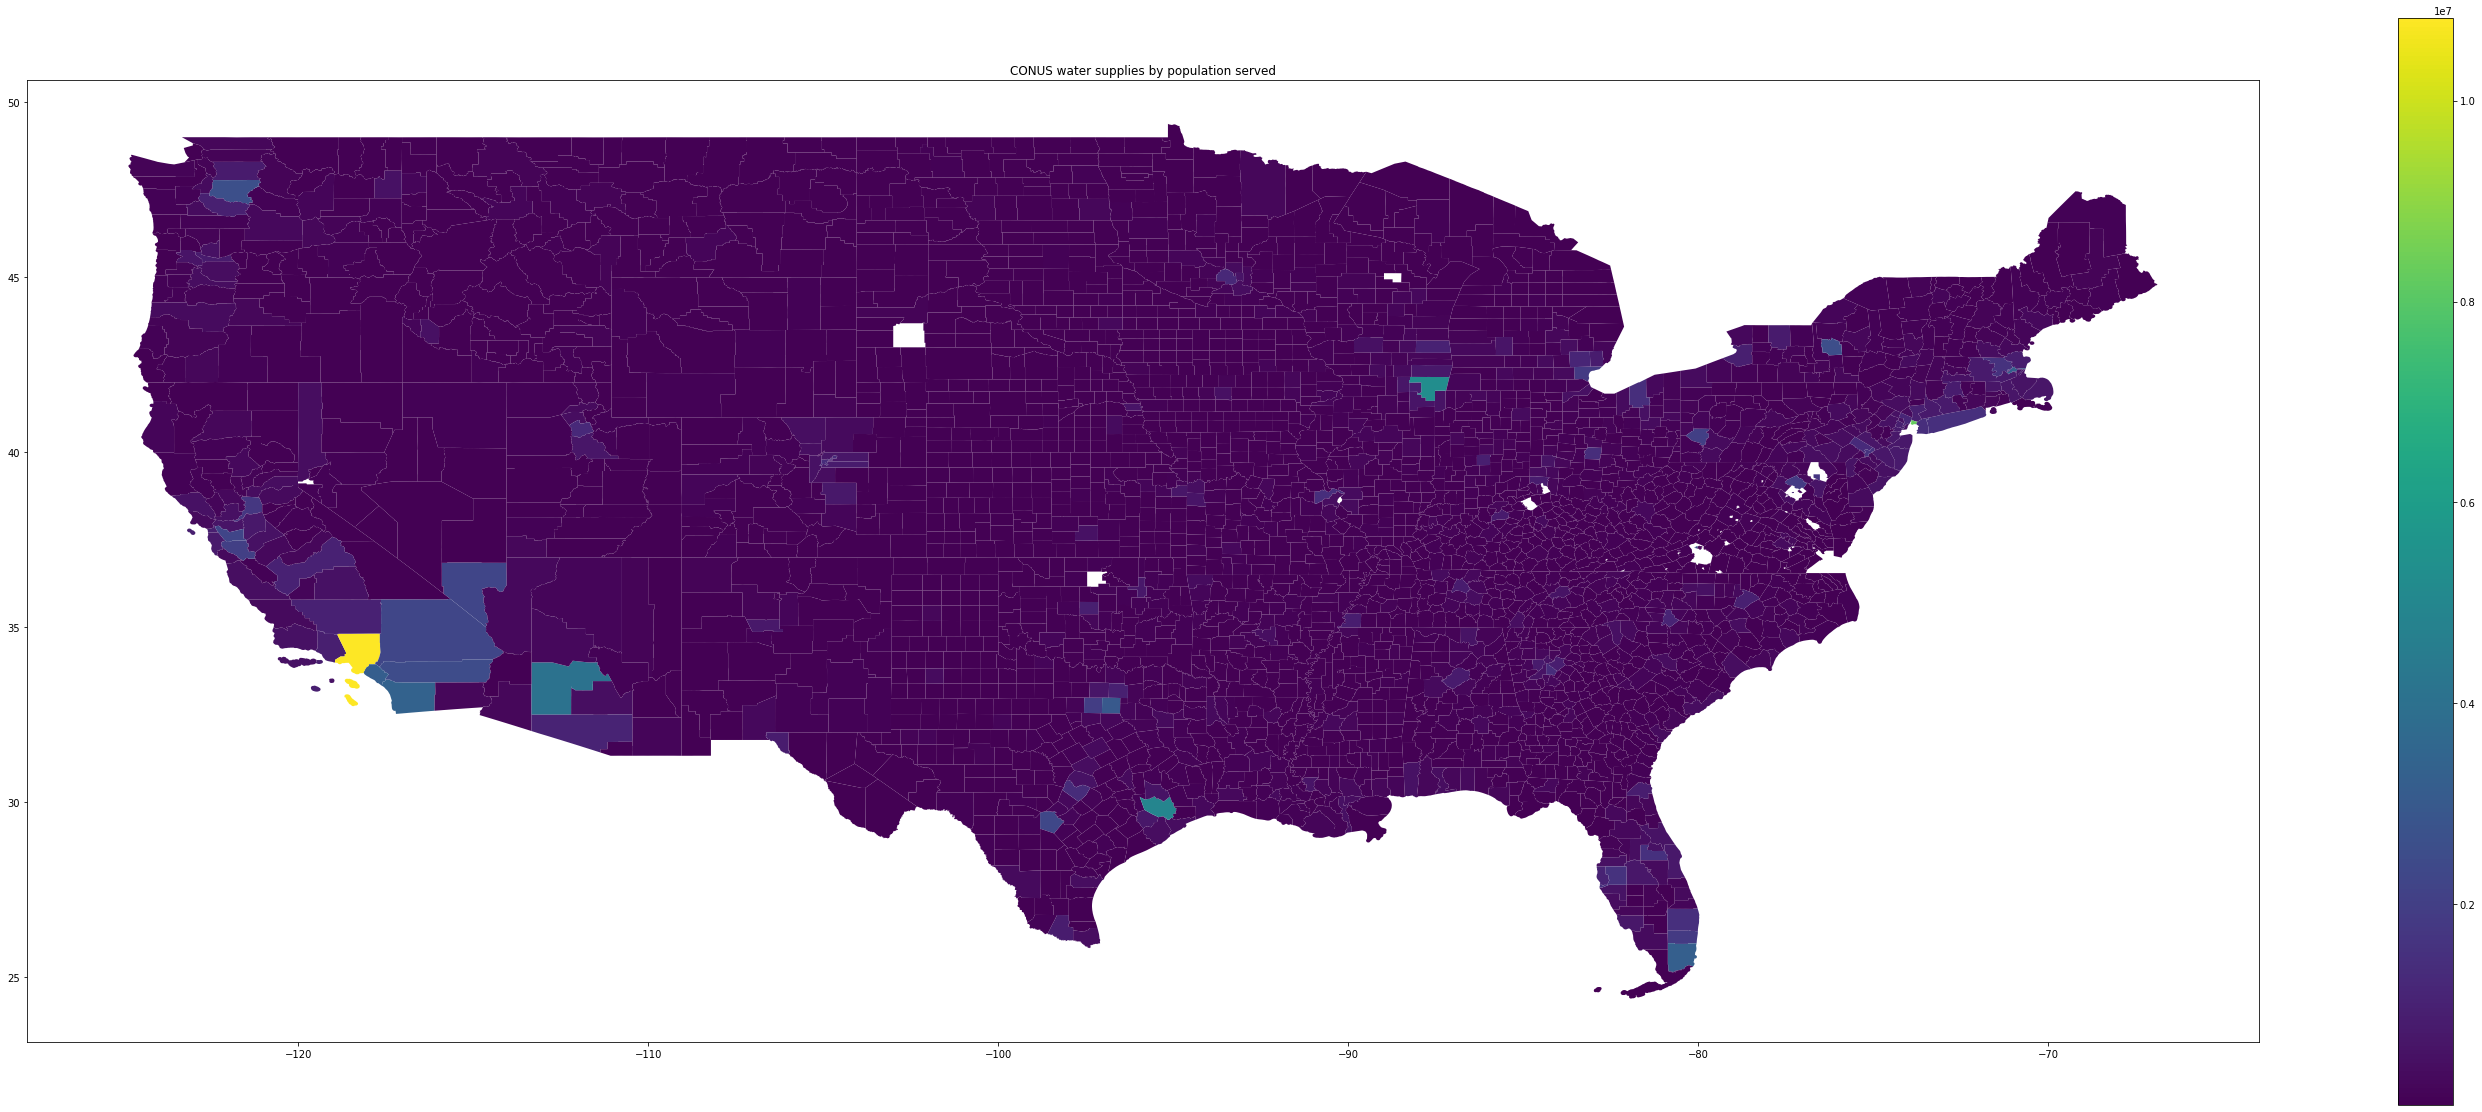

In [412]:
fig,ax = plt.subplots(figsize=(50,20))
gdf_USCountyWaterSupplies.cx[-125:-50, 20:70].plot("PopulationServed Count",ax=ax,legend="True")
ax.set_title("CONUS water supplies by population served")

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  fig.canvas.print_figure(bytes_io, **kw)


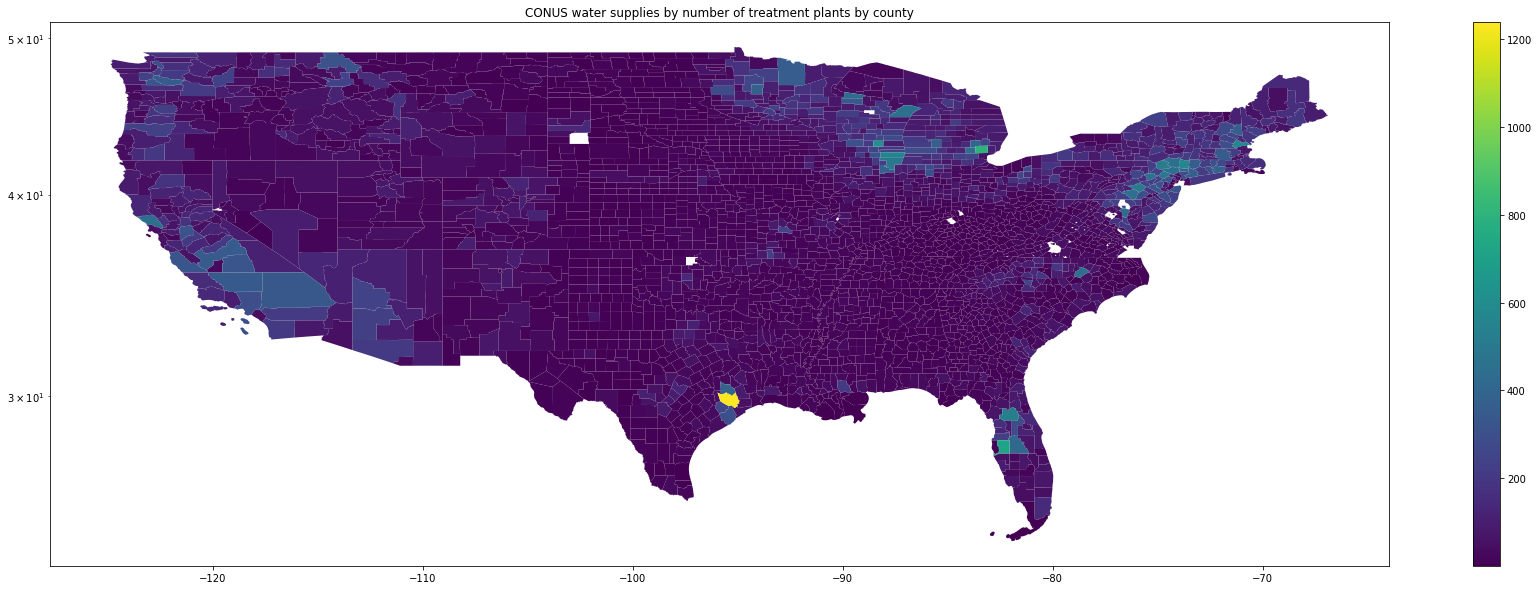

In [413]:
fig,ax = plt.subplots(figsize=(30,10))
gdf_USCountyWaterSupplies.cx[-125:-50, 20:60].plot("PWS ID",ax=ax,legend="True")
ax.set_title("CONUS water supplies by number of treatment plants by county")
ax.set_yscale("log")

Now decide on the population served thresholds based on operator numbers

Text(0, 0.5, 'Frequency (Log Scale)')

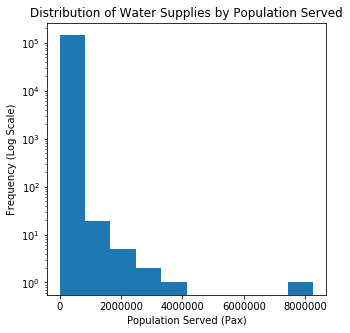

In [414]:
fig,ax = plt.subplots(figsize=(5,5))
df_AllStateWaterSupplies["PopulationServed Count"].plot(kind="hist",ax=ax)
ax.set_yscale("log")
ax.set_title("Distribution of Water Supplies by Population Served")
ax.set_xlabel("Population Served (Pax)")
ax.set_ylabel("Frequency (Log Scale)")

Text(0, 0.5, 'Number of Supplies (Log Scale)')

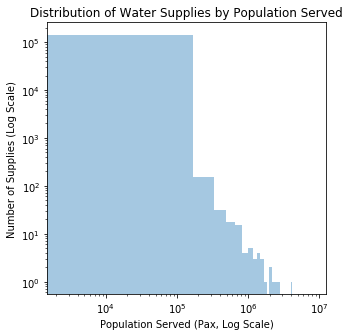

In [415]:
fig,ax = plt.subplots(figsize=(5,5))
sns.distplot(df_AllStateWaterSupplies["PopulationServed Count"],ax=ax,kde=False)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title("Distribution of Water Supplies by Population Served")
ax.set_xlabel("Population Served (Pax, Log Scale)")
ax.set_ylabel("Number of Supplies (Log Scale)")

In [416]:
df_AllStateWaterSupplies.sort_values("PopulationServed Count",ascending=False)

PWS ID                                  PWS Name  \
87364   NY7003493                      NEW YORK CITY SYSTEM   
6030    CA1910067  LOS ANGELES-CITY, DEPT. OF WATER & POWER   
28854   IL0316000                                   CHICAGO   
40985   MA6000000                                      MWRA   
115058  TX1010013                           CITY OF HOUSTON   
...           ...                                       ...   
48096   MI0002836              GRATIOT AREA WATER AUTHORITY   
48099   MI0002838               GREAT LAKES WATER AUTHORITY   
114487  TX0200497                BRAZOSPORT WATER AUTHORITY   
2170    AR0001077                    FRANKLIN-SEBASTIAN PWA   
5821    CA1510040                  KERN COUNTY WATER AGENCY   

                      PWS Type           Primary Source  \
87364   Community water system            Surface water   
6030    Community water system            Surface water   
28854   Community water system            Surface water   
40985   Community water system            Surface water   
115058  Community water system            Surface water   
...                        ...                      ...   
48096   Community water system            Surface water   
48099   Community water system            Surface water   
114487  Community water system            Surface water   
2170    Community water system  Surface water purchased   
5821    Community water system            Surface water   

                                 Counties Served Cities Served  \
87364   Bronx, Kings, New York, Queens, Richmond  NEW YORK (C)   
6030                                 Los Angeles   LOS ANGELES   
28854                                       Cook             -   
40985                                    Suffolk        BOSTON   
115058                                    Harris             -   
...                                          ...           ...   
48096                                    Gratiot             -   
48099                                      Wayne       DETROIT   
114487                                  Brazoria             -   
2170                                   Sebastian             -   
5821                                        Kern             -   

        PopulationServed Count  Number of Facilities  Number of Violations  \
87364                  8271000                   162                    24   
6030                   4085000                   369                     7   
28854                  2700000                    31                    44   
40985                  2550000                    45                     3   
115058                 2319603                  1181                     6   
...                        ...                   ...                   ...   
48096                        0                     9                     0   
48099                        0                    10                     0   
114487                       0                     9                     8   
2170                         0                     3                     2   
5821                         0                    34                     0   

        Number of Site Visits State           Name Postal Code  FIPS  \
87364                     174    NY       New York          NY    36   
6030                      287    CA     California          CA     6   
28854                      36    IL       Illinois          IL    17   
40985                      20    MA  Massachusetts          MA    25   
115058                     20    TX          Texas          TX    48   
...                       ...   ...            ...         ...   ...   
48096                      12    MI       Michigan          MI    26   
48099                      26    MI       Michigan          MI    26   
114487                     13    TX          Texas          TX    48   
2170                        3    AR       Arkansas          AR     5   
5821                   

In [417]:
df_AllStateWaterSupplies["Base 10 Population Served"] = np.log10(df_AllStateWaterSupplies["PopulationServed Count"])

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [418]:
gdf_USCountyWaterSupplies["Base 10 Population Served"] = np.log10(gdf_USCountyWaterSupplies["PopulationServed Count"])

Text(0.5, 1, 'CONUS water supplies by population served (log scale)')

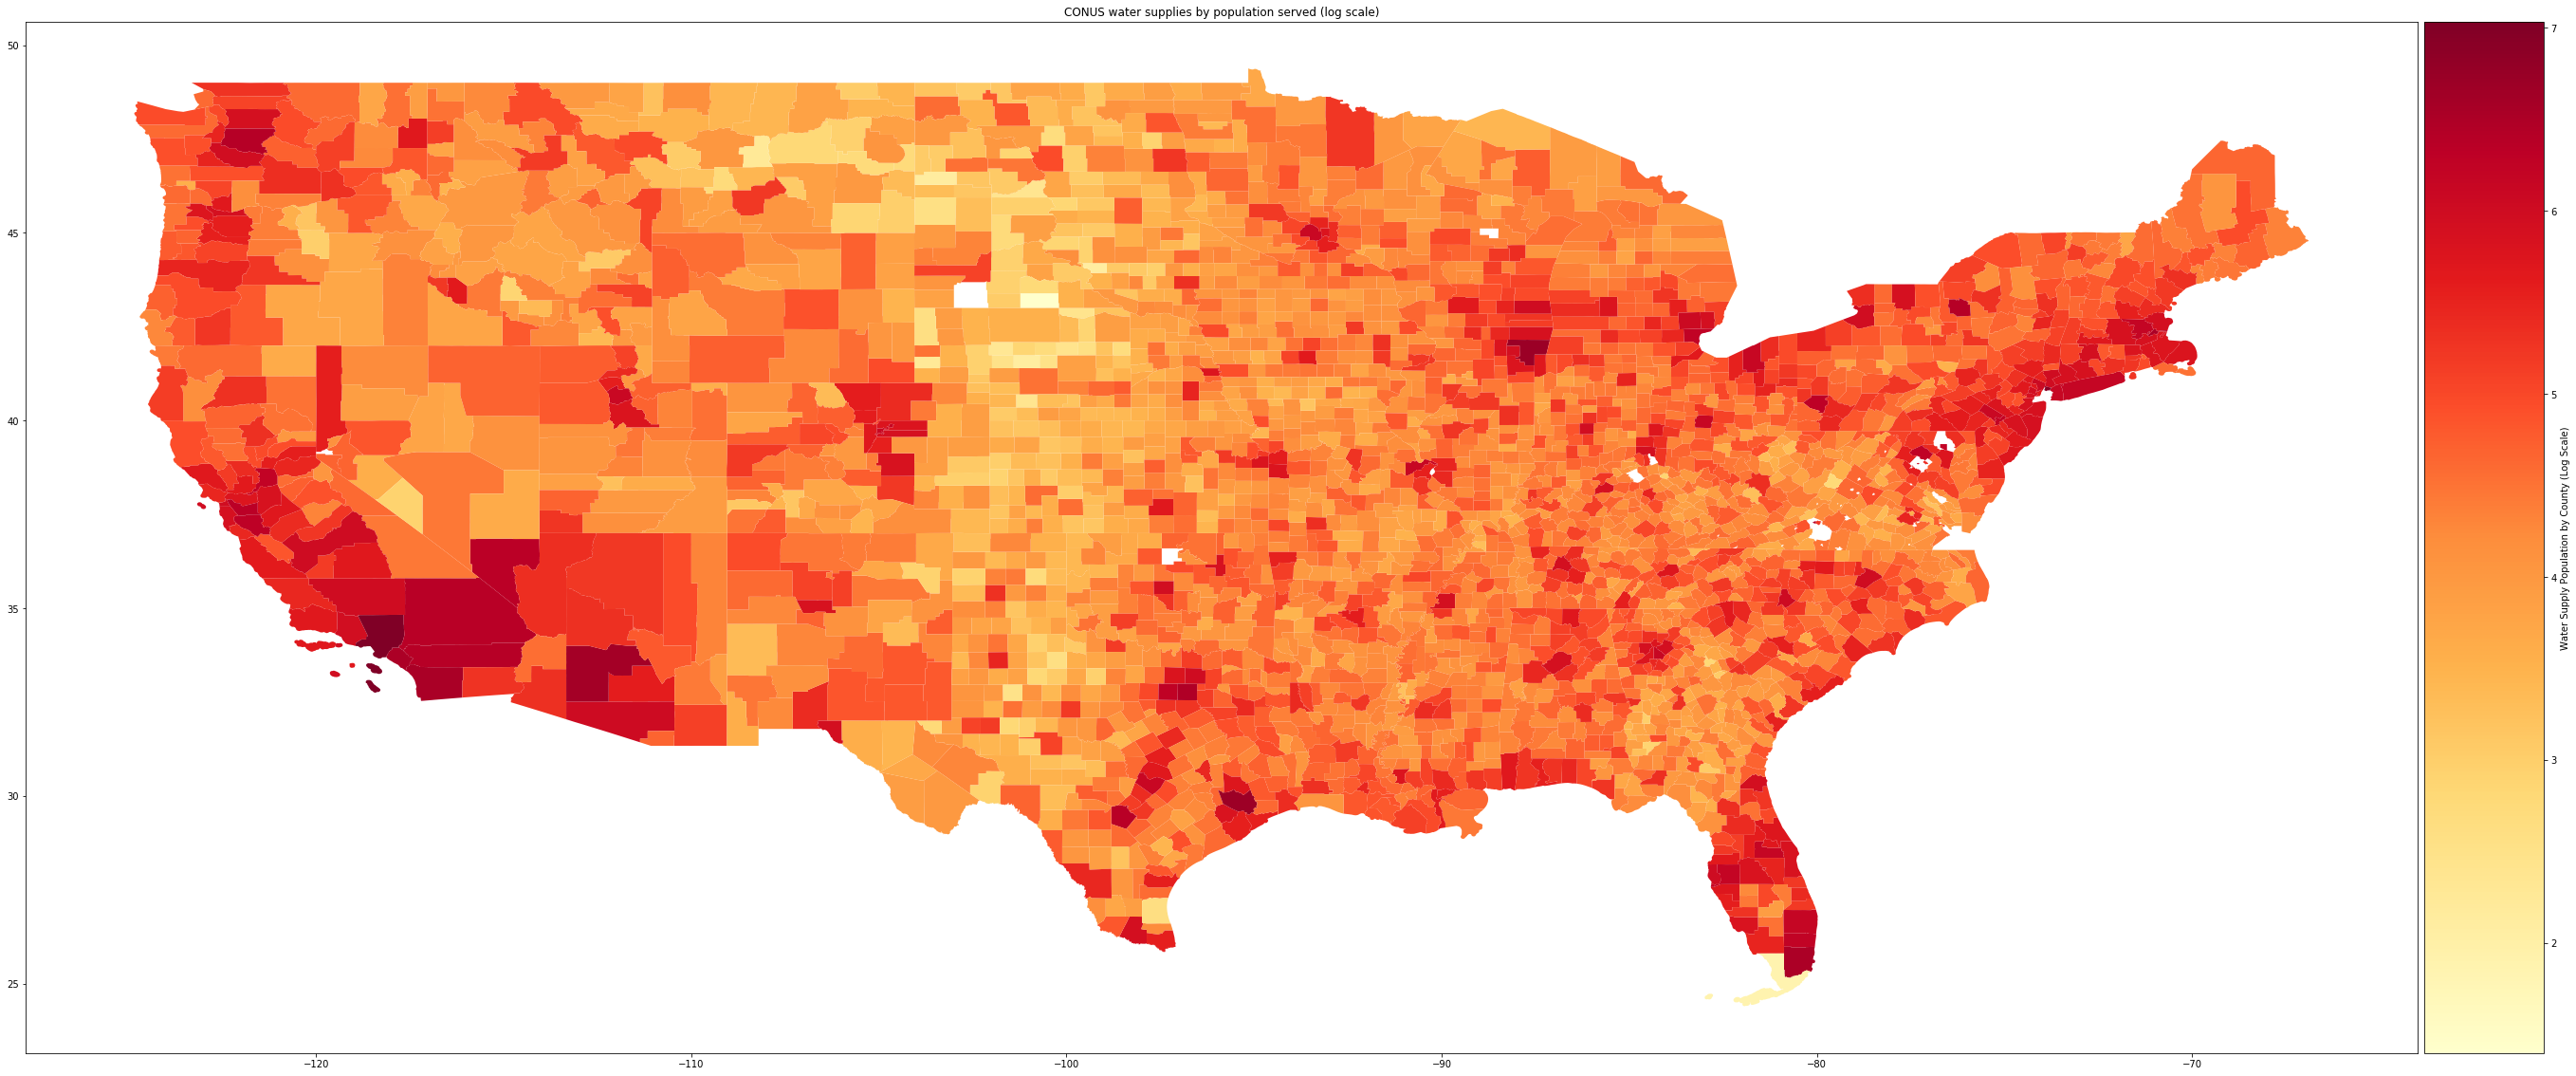

In [419]:
fig,ax = plt.subplots(figsize=(50,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
gdf_USCountyWaterSupplies.cx[-125:-50, 20:70].plot("Base 10 Population Served",ax=ax,cax=cax,legend="True",cmap="YlOrRd",
                                                  legend_kwds={'label': "Water Supply Population by County (Log Scale)"})
ax.set_title("CONUS water supplies by population served (log scale)")

Load employment data

In [238]:
df_BLSIndustries = pd.read_excel(excel_BLSIndustries) # https://data.bls.gov/cew/doc/titles/industry/industry_titles.htm

In [242]:
df_IndustriesToStartWith = df_BLSIndustries[df_BLSIndustries["High Level Include"]=="Yes"]

In [467]:
df_IndustriesToStartWith_PrettyNames = ["(2211): Power Generation and Supply Workforce",
                                        "(2212): Natural Gas Distribution Workorce",
                                        "(2213): Overall Water and Wastewater Workforce",
                                        "(22131): Water Sector Workforce",
                                        "(22132): Wastewater Sector Workforce",
                                        "(23711): Water and Wastewater Construction Workforce",
                                        "(23712): Oil and Gas Pipeline Construction Workforce",
                                        "(23713): Power and Communication Systems Construction Workforce",
                                        "(2373): Transportation Construction Workforce",
                                        "(92411): Air, Water, and Waste Government Administration Workforce",
                                        "(92613): Utility Regulation adn Administration Workforce"
                                       ]

In [470]:
df_IndustriesToStartWith["Pretty Name"] = df_IndustriesToStartWith_PrettyNames

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [471]:
df_IndustriesToStartWith

industry_code                                     industry_title Include  \
199           2211             NAICS 2211 Power generation and supply     Yes   
213           2212                NAICS 2212 Natural gas distribution     Yes   
216           2213         NAICS 2213 Water, sewage and other systems     Yes   
217          22131    NAICS 22131 Water supply and irrigation systems     Yes   
219          22132            NAICS 22132 Sewage treatment facilities     Yes   
238          23711    NAICS 23711 Water and sewer system construction     Yes   
240          23712      NAICS 23712 Oil and gas pipeline construction     Yes   
242          23713  NAICS 23713 Power and communication system con...     Yes   
247           2373  NAICS 2373 Highway, street, and bridge constru...     Yes   
2460         92411  NAICS 92411 Air, water, and waste program admi...     Yes   
2476         92613  NAICS 92613 Utility regulation and administration     Yes   

     High Level Include                                        Pretty Name  
199                 Yes      (2211): Power Generation and Supply Workforce  
213                 Yes          (2212): Natural Gas Distribution Workorce  
216                 Yes     (2213): Overall Water and Wastewater Workforce  
217                 Yes                    (22131): Water Sector Workforce  
219                 Yes               (22132): Wastewater Sector Workforce  
238                 Yes  (23711): Water and Wastewater Construction Wor...  
240                 Yes  (23712): Oil and Gas Pipeline Construction Wor...  
242                 Yes  (23713): Power and Communication Systems Const...  
247                 Yes      (2373): Transportation Construction Workforce  
2460                Yes  (92411): Air, Water, and Waste Government Admi...  
2476                Yes  (92613): Utility Regulation adn Administration...

In [222]:
df_EmploymentData = pd.read_csv(csv_EmployementData2019Q1) # https://data.bls.gov/cew/doc/layouts/csv_quarterly_layout.htm

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [263]:
df_EmploymentData["area_fips"] = df_EmploymentData["area_fips"].astype("str")

In [264]:
df_EmploymentData.head()

area_fips  own_code industry_code  agglvl_code  size_code  year  qtr  \
0      1000         0            10           50          0  2019    1   
1      1000         0            10           50          0  2019    2   
2      1000         0            10           50          0  2019    3   
3      1000         1            10           51          0  2019    1   
4      1000         1            10           51          0  2019    2   

  disclosure_code  qtrly_estabs  month1_emplvl  month2_emplvl  month3_emplvl  \
0             NaN        127988        1956476        1969122        1977658   
1             NaN        129541        1988655        1994384        1996581   
2             NaN        130945        1985355        1992827        1989525   
3             NaN          1216          53337          53588          53497   
4             NaN          1217          53600          53690          53928   

   total_qtrly_wages  taxable_qtrly_wages  qtrly_contributions  avg_wkly_wage  \
0        24160364990           9849675204            119169491            944   
1        23576562606           2588522394             32388053            910   
2        23766427185           1746589241             22396887            919   
3         1106955506                    0                    0           1592   
4         1121140925                    0                    0           1605   

  lq_disclosure_code  lq_qtrly_estabs  lq_month1_emplvl  lq_month2_emplvl  \
0                NaN             1.00              1.00              1.00   
1                NaN             1.00              1.00              1.00   
2                NaN             1.00              1.00              1.00   
3                NaN             1.61              1.42              1.42   
4                NaN             1.61              1.42              1.42   

   lq_month3_emplvl  lq_total_qtrly_wages  lq_taxable_qtrly_wages  \
0              1.00                  1.00                     1.0   
1              1.00                  1.00                     1.0   
2              1.00                  1.00                     1.0   
3              1.42                  1.86                     0.0   
4              1.42                  1.68                     0.0   

   lq_qtrly_contributions  lq_avg_wkly_wage oty_disclosure_code  \
0                     1.0              1.00                 NaN   
1                     1.0              1.00                 NaN   
2                     1.0              1.00                 NaN   
3                     0.0              1.31                 NaN   
4                     0.0              1.18                 NaN   

   oty_qtrly_estabs_chg  oty_qtrly_estabs_pct_chg  oty_month1_emplvl_chg  \
0                  2353                       1.9                  35545   
1                  3162                       2.5                  30587   
2                  3453                       2.7                  28727   
3                    24                       2.0                    791   
4                    22                       1.8                    916   

   oty_month1_emplvl_pct_chg  oty_month2_emplvl_chg  \
0                        1.9                  32977   
1                        1.6                  31983   
2                        1.5                  28502   
3                        1.5                   1024   
4                        1.7                   1114   

   oty_month2_emplvl_pct_chg  oty_month3_emplvl_chg  \
0                        1.7                  30223   
1                        1.6                  24604   
2                        1.5                  22417   
3                        1.9                    921   
4                        2.1                   1061   

   oty_month3_emplvl_pct_chg  oty_total_qtrly_wages_chg  \
0                        1.6                 1004646638   
1                        1.2                 1069251441   
2           

In [265]:
# Columns to track
fipsColumn = "area_fips"
industryCodeColumn = "industry_code"
nEstabColumn = "qtrly_estabs"
nEmployeesColumn = "month3_emplvl"
locationQuotientNEmployeesColumn = "lq_month3_emplvl"

In [420]:
df_employment_industry_subset.index

Index(['1000', '10000', '1059', '1069', '1071', '1083', '1089', '10999',
       '11000', '11001',
       ...
       '8067', '8069', '8103', '8999', '9000', '9003', '9007', '9011', '9999',
       'US000'],
      dtype='object', name='area_fips', length=613)

In [441]:
for i,row in df_IndustriesToStartWith.iterrows():
    industry_code = row["industry_code"]
    industry_title = row["industry_title"]
    df_employment_industry_subset = df_EmploymentData[(df_EmploymentData[industryCodeColumn] == str(industry_code)) & (df_EmploymentData["qtr"]==3)][[fipsColumn,industryCodeColumn,nEstabColumn,nEmployeesColumn,locationQuotientNEmployeesColumn]].groupby("area_fips").sum() # kludge, sum by area_fips to make sure unique
    df_employment_industry_subset.columns = [f"{industry_title}_{col}" for col in df_employment_industry_subset.columns]
    
    # create merge column
    df_employment_industry_subset["County FIPS INT"] = df_employment_industry_subset.index
    df_employment_industry_subset["County FIPS INT"] = pd.to_numeric(df_employment_industry_subset["County FIPS INT"],errors="coerce") # set non numeric to na
    df_employment_industry_subset.dropna(subset=['County FIPS INT'],inplace=True) # get rid of na
    df_employment_industry_subset["County FIPS INT"] = df_employment_industry_subset["County FIPS INT"].astype("int") # convert to int

    
    # create log scale
    for col in df_employment_industry_subset.columns:
        logColName = f"{col}_log10Scale"
        df_employment_industry_subset[logColName] = np.log10(df_employment_industry_subset[col])
    gdf_USCountyWaterSupplies = pd.merge(left=gdf_USCountyWaterSupplies,right=df_employment_industry_subset,left_on="County FIPS INT",right_on="County FIPS INT",how="left")

In [442]:
gdf_USCountyWaterSupplies = gdf_USCountyWaterSupplies.replace(np.nan,0).replace(-np.inf,0)

In [443]:
gdf_USCountyWaterSupplies.head()

STATEFP COUNTYFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD CLASSFP  \
0      31      039  00835841  31039     Cuming     Cuming County   06      H1   
1      53      069  01513275  53069  Wahkiakum  Wahkiakum County   06      H1   
2      35      011  00933054  35011    De Baca    De Baca County   06      H1   
3      31      109  00835876  31109  Lancaster  Lancaster County   06      H1   
4      31      129  00835886  31129   Nuckolls   Nuckolls County   06      H1   

   MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND    AWATER     INTPTLAT  \
0  G4020     0      0        0        A  1477641638  10701538  +41.9158651   
1  G4020     0      0        0        A   680956787  61588406  +46.2946377   
2  G4020     0      0        0        A  6016761648  29147345  +34.3592729   
3  G4020   339  30700        0        A  2169252486  22867561  +40.7835474   
4  G4020     0      0        0        A  1489645186   1718484  +40.1764918   

       INTPTLON                                           geometry  \
0  -096.7885168  POLYGON ((-97.01952 42.00410, -97.01952 42.004...   
1  -123.4244583  POLYGON ((-123.43639 46.23820, -123.44759 46.2...   
2  -104.3686961  POLYGON ((-104.56739 33.99757, -104.56772 33.9...   
3  -096.6886584  POLYGON ((-96.91060 40.95841, -96.91060 40.958...   
4  -098.0468422  POLYGON ((-98.27367 40.08940, -98.27367 40.089...   

   PopulationServed Count  PWS ID  County FIPS INT  Base 10 Population Served  \
0                    7925       9            31039                   3.898999   
1                    3674       6            53069                   3.565139   
2                    2274       4            35011                   3.356790   
3                  303192      95            31109                   5.481718   
4                    3125       6            31129                   3.494850   

   NAICS 2211 Power generation and supply_qtrly_estabs  \
0                                                1.0     
1                                                1.0     
2                                                1.0     
3                                               10.0     
4                                                1.0     

   NAICS 2211 Power generation and supply_month3_emplvl  \
0                                                0.0      
1                                                0.0      
2                                                0.0      
3                                              639.0      
4                                                0.0      

   NAICS 2211 Power generation and supply_lq_month3_emplvl  \
0                                               0.00         
1                                               0.00         
2                                               0.00         
3                                               7.17         
4                                               0.00         

   NAICS 2211 Power generation and supply_qtrly_estabs_log10Scale  \
0                                                0.0                
1                                                0.0                
2                                                0.0                
3                                                1.0                
4                                                0.0                

   NAICS 2211 Power generation and supply_month3_emplvl_log10Scale  \
0                                           0.000000                 
1                                           0.000000                 
2                                           0.000000                 
3                                           2.805501                 
4                                           0.000000                 

   NAICS 2211 Power generation and supply_lq_month3_emplvl_log10Scale  \
0                                           0.000000                    
1                                           0.000000                    
2     

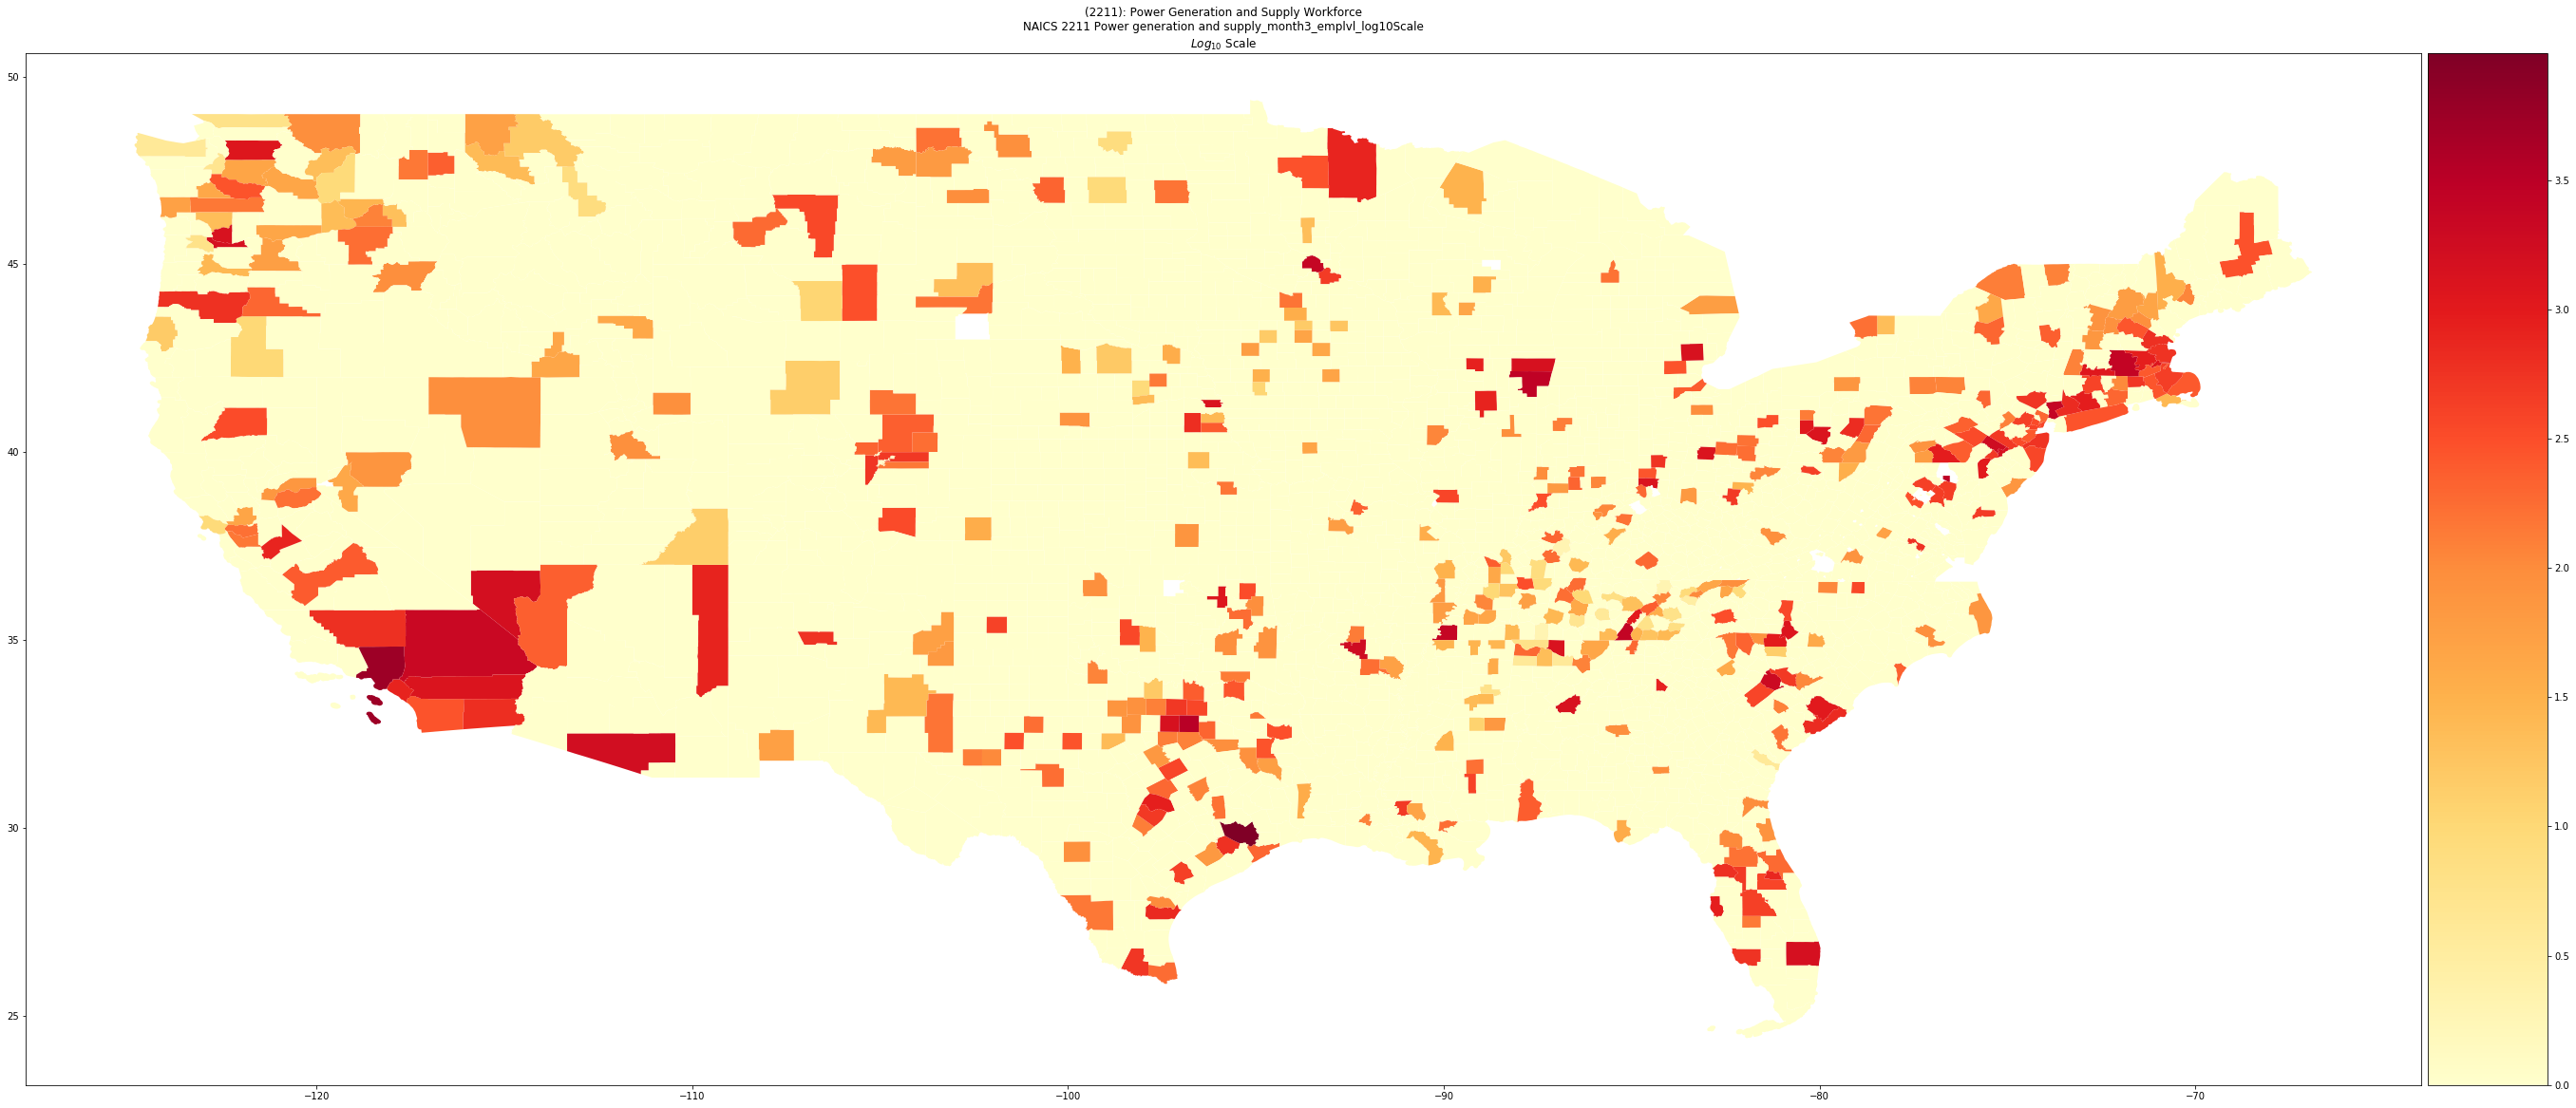

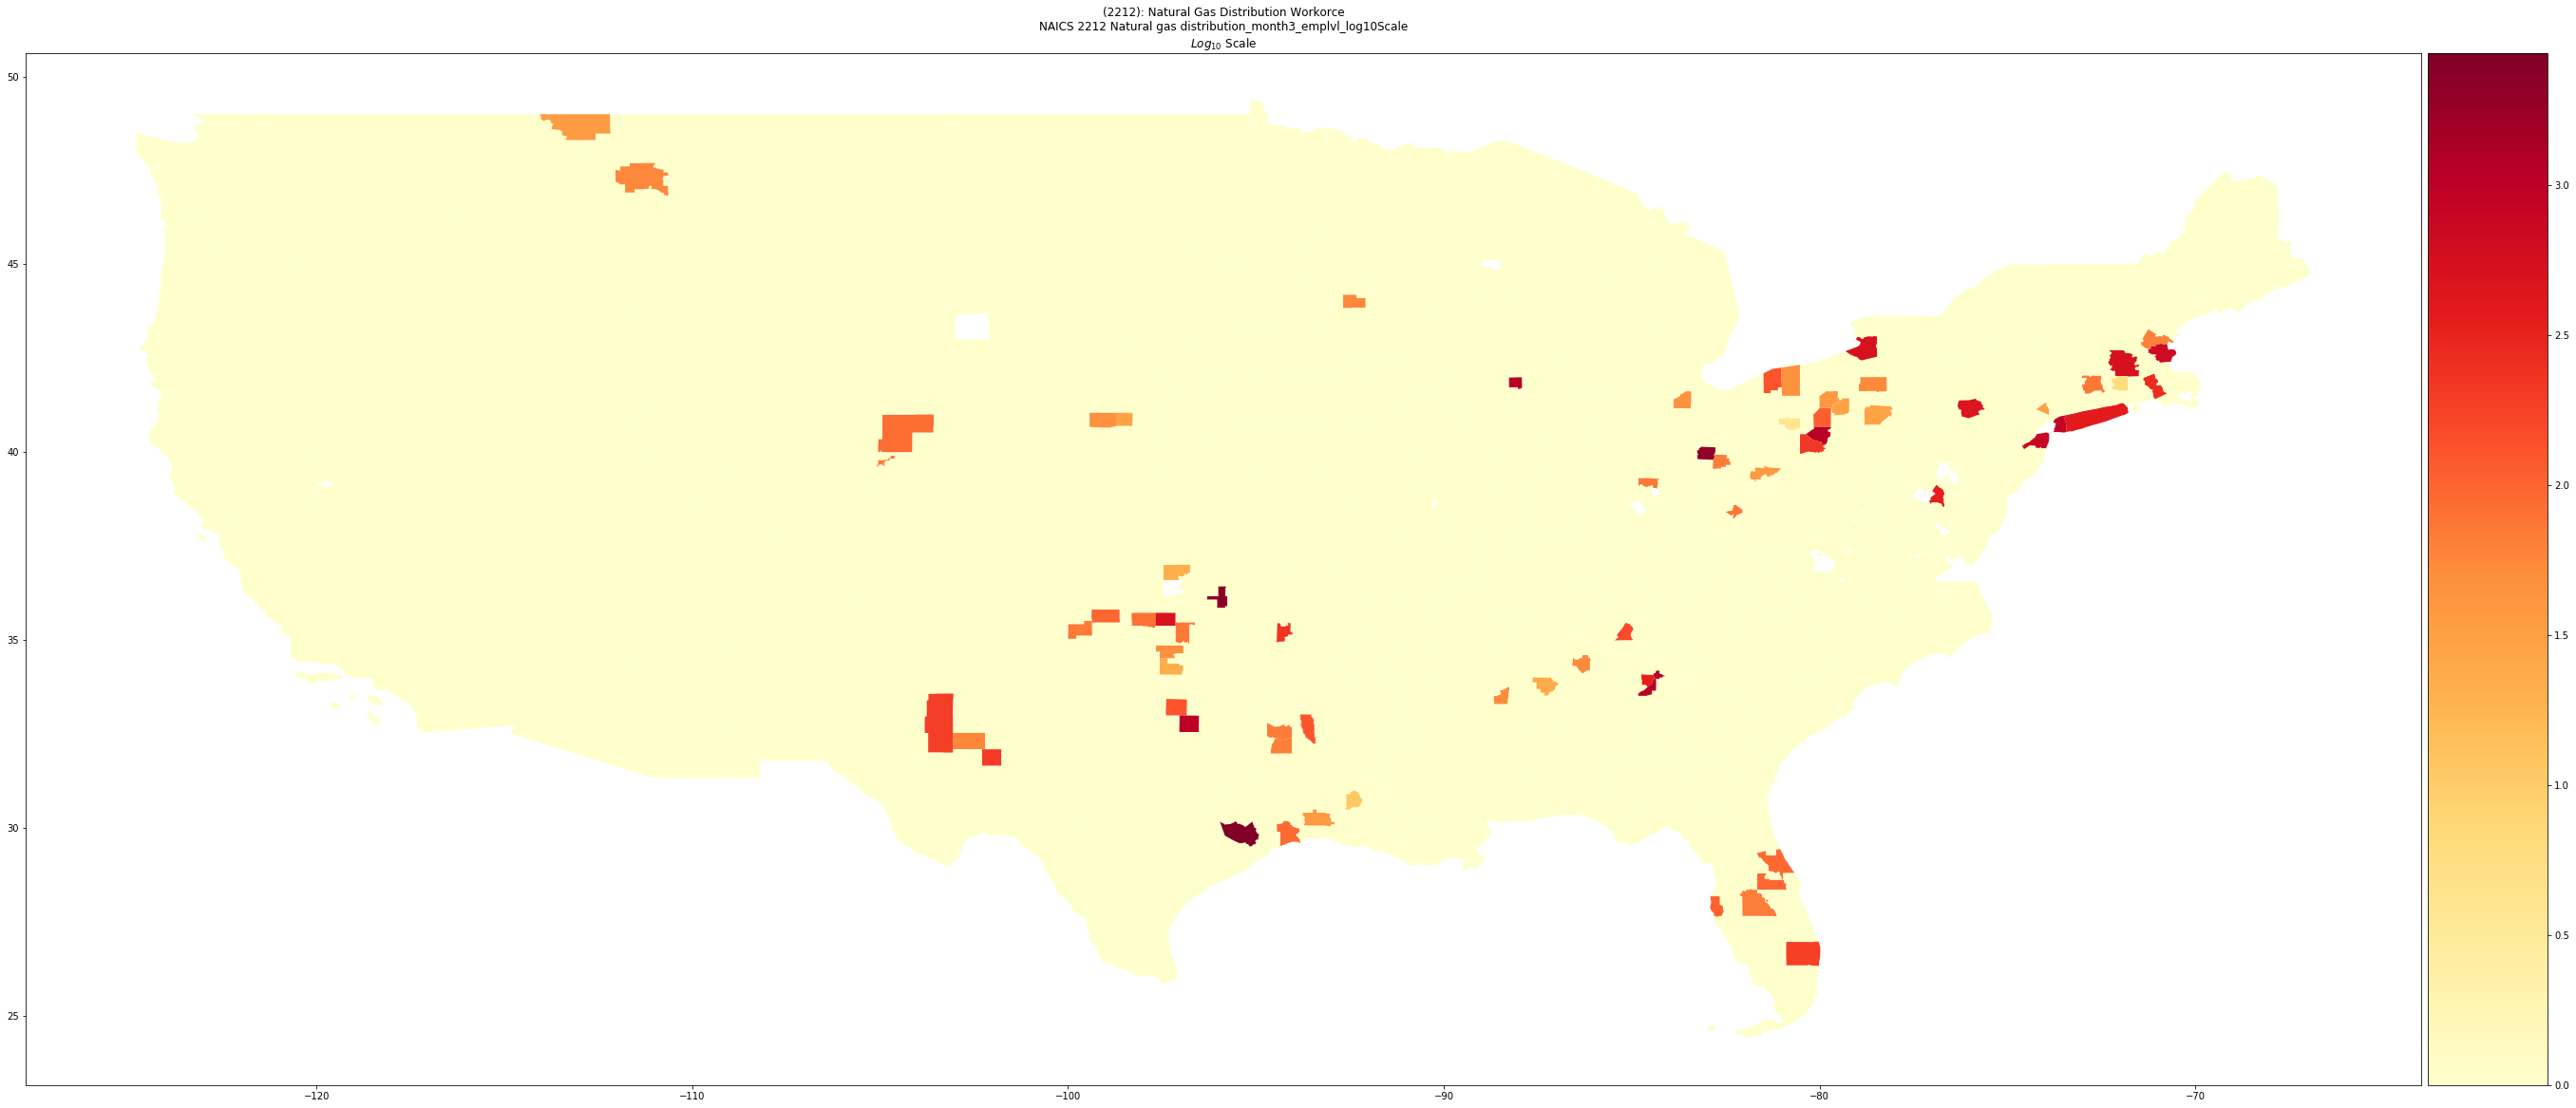

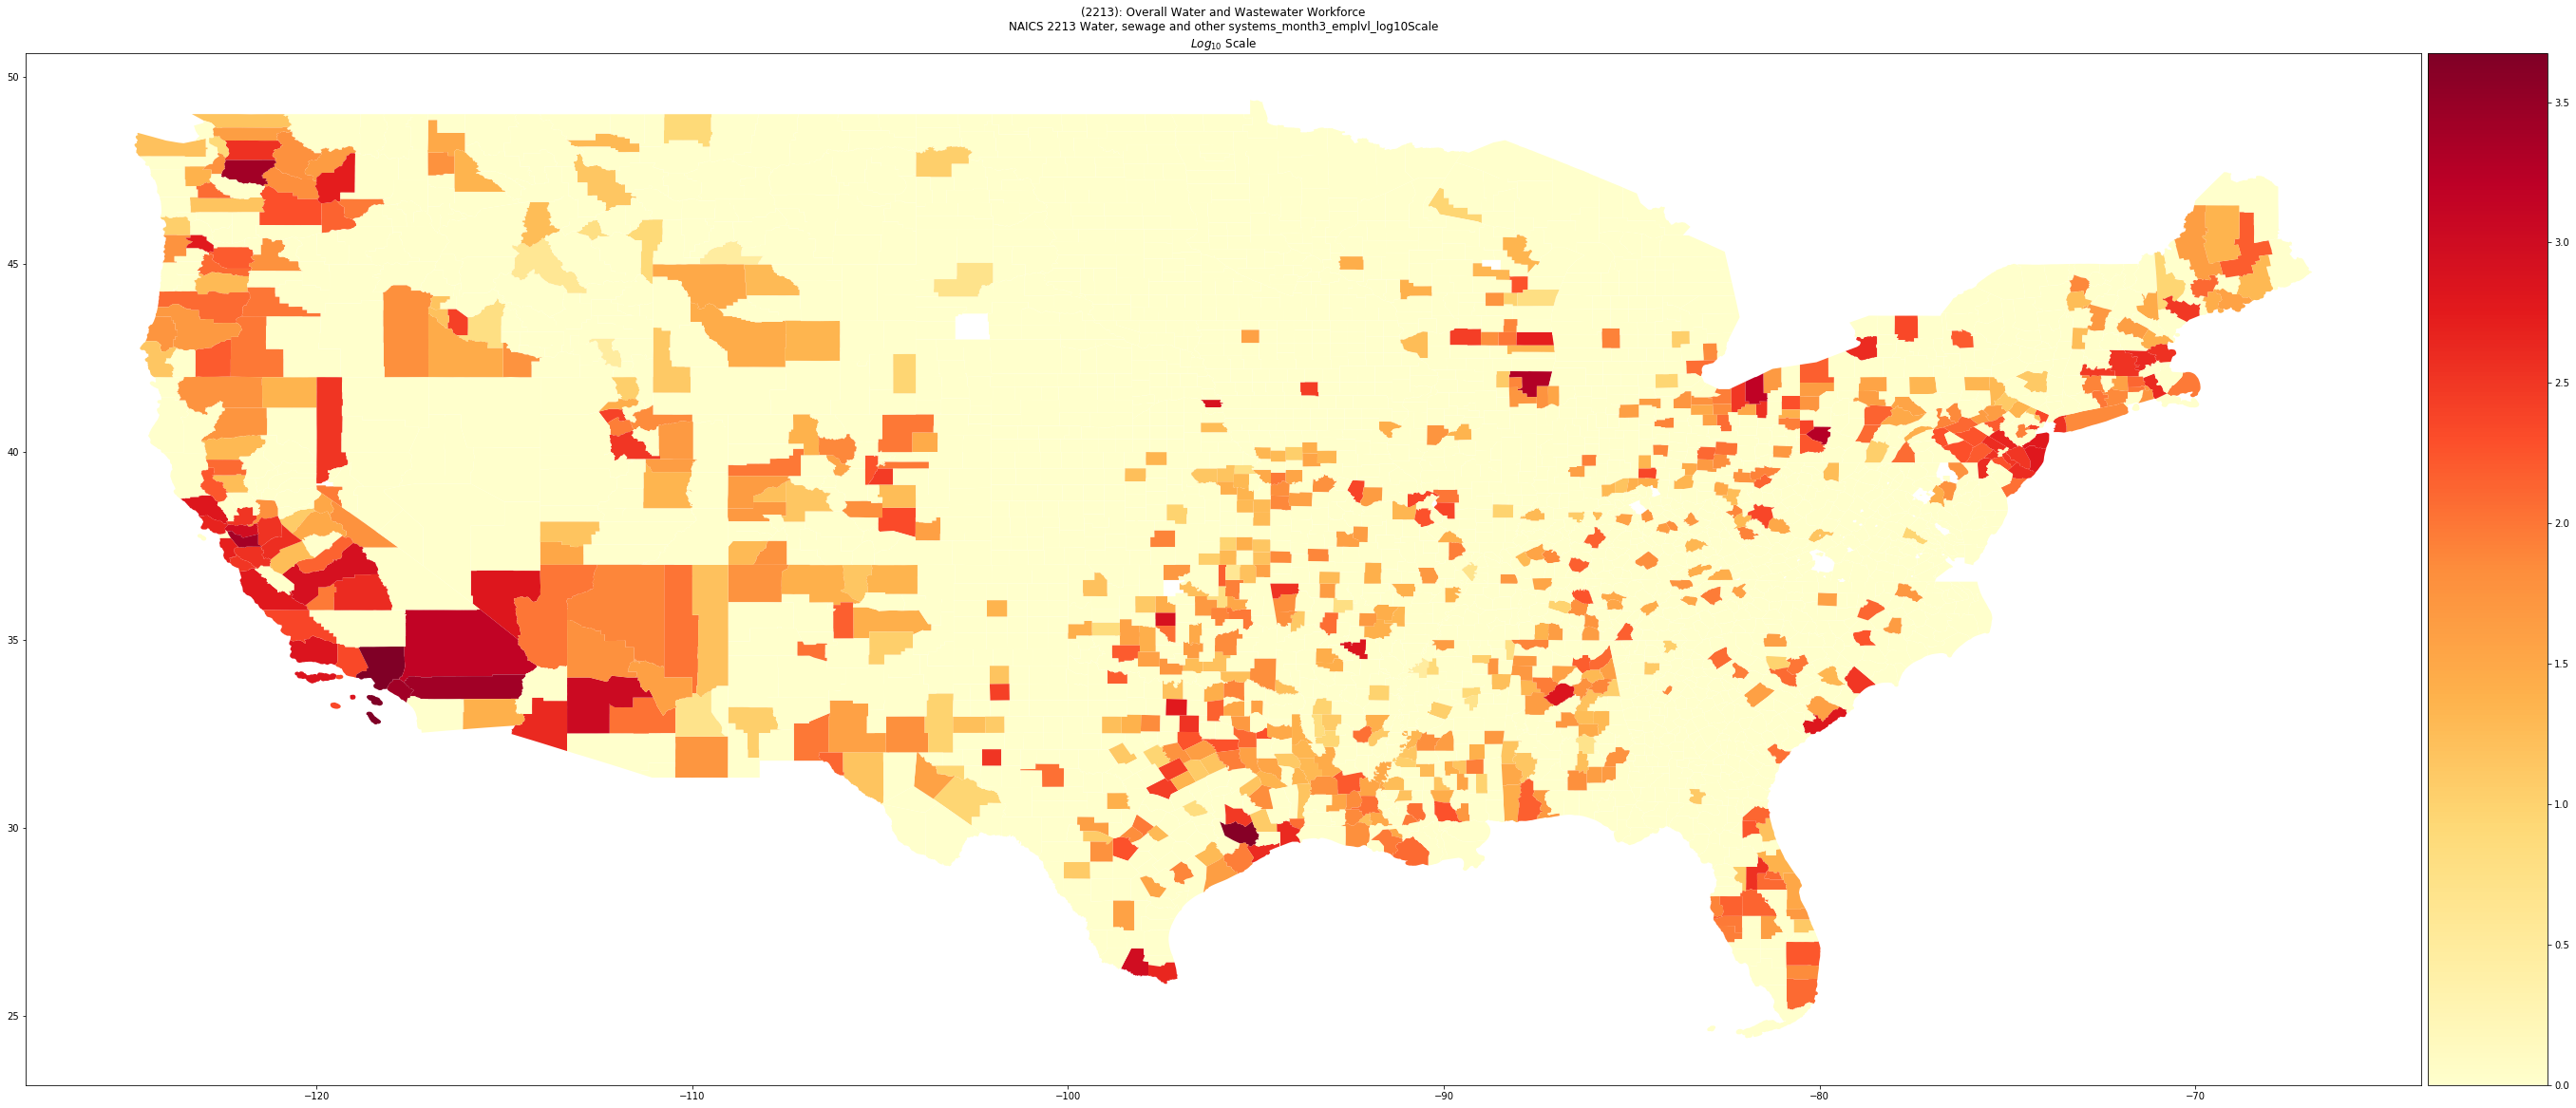

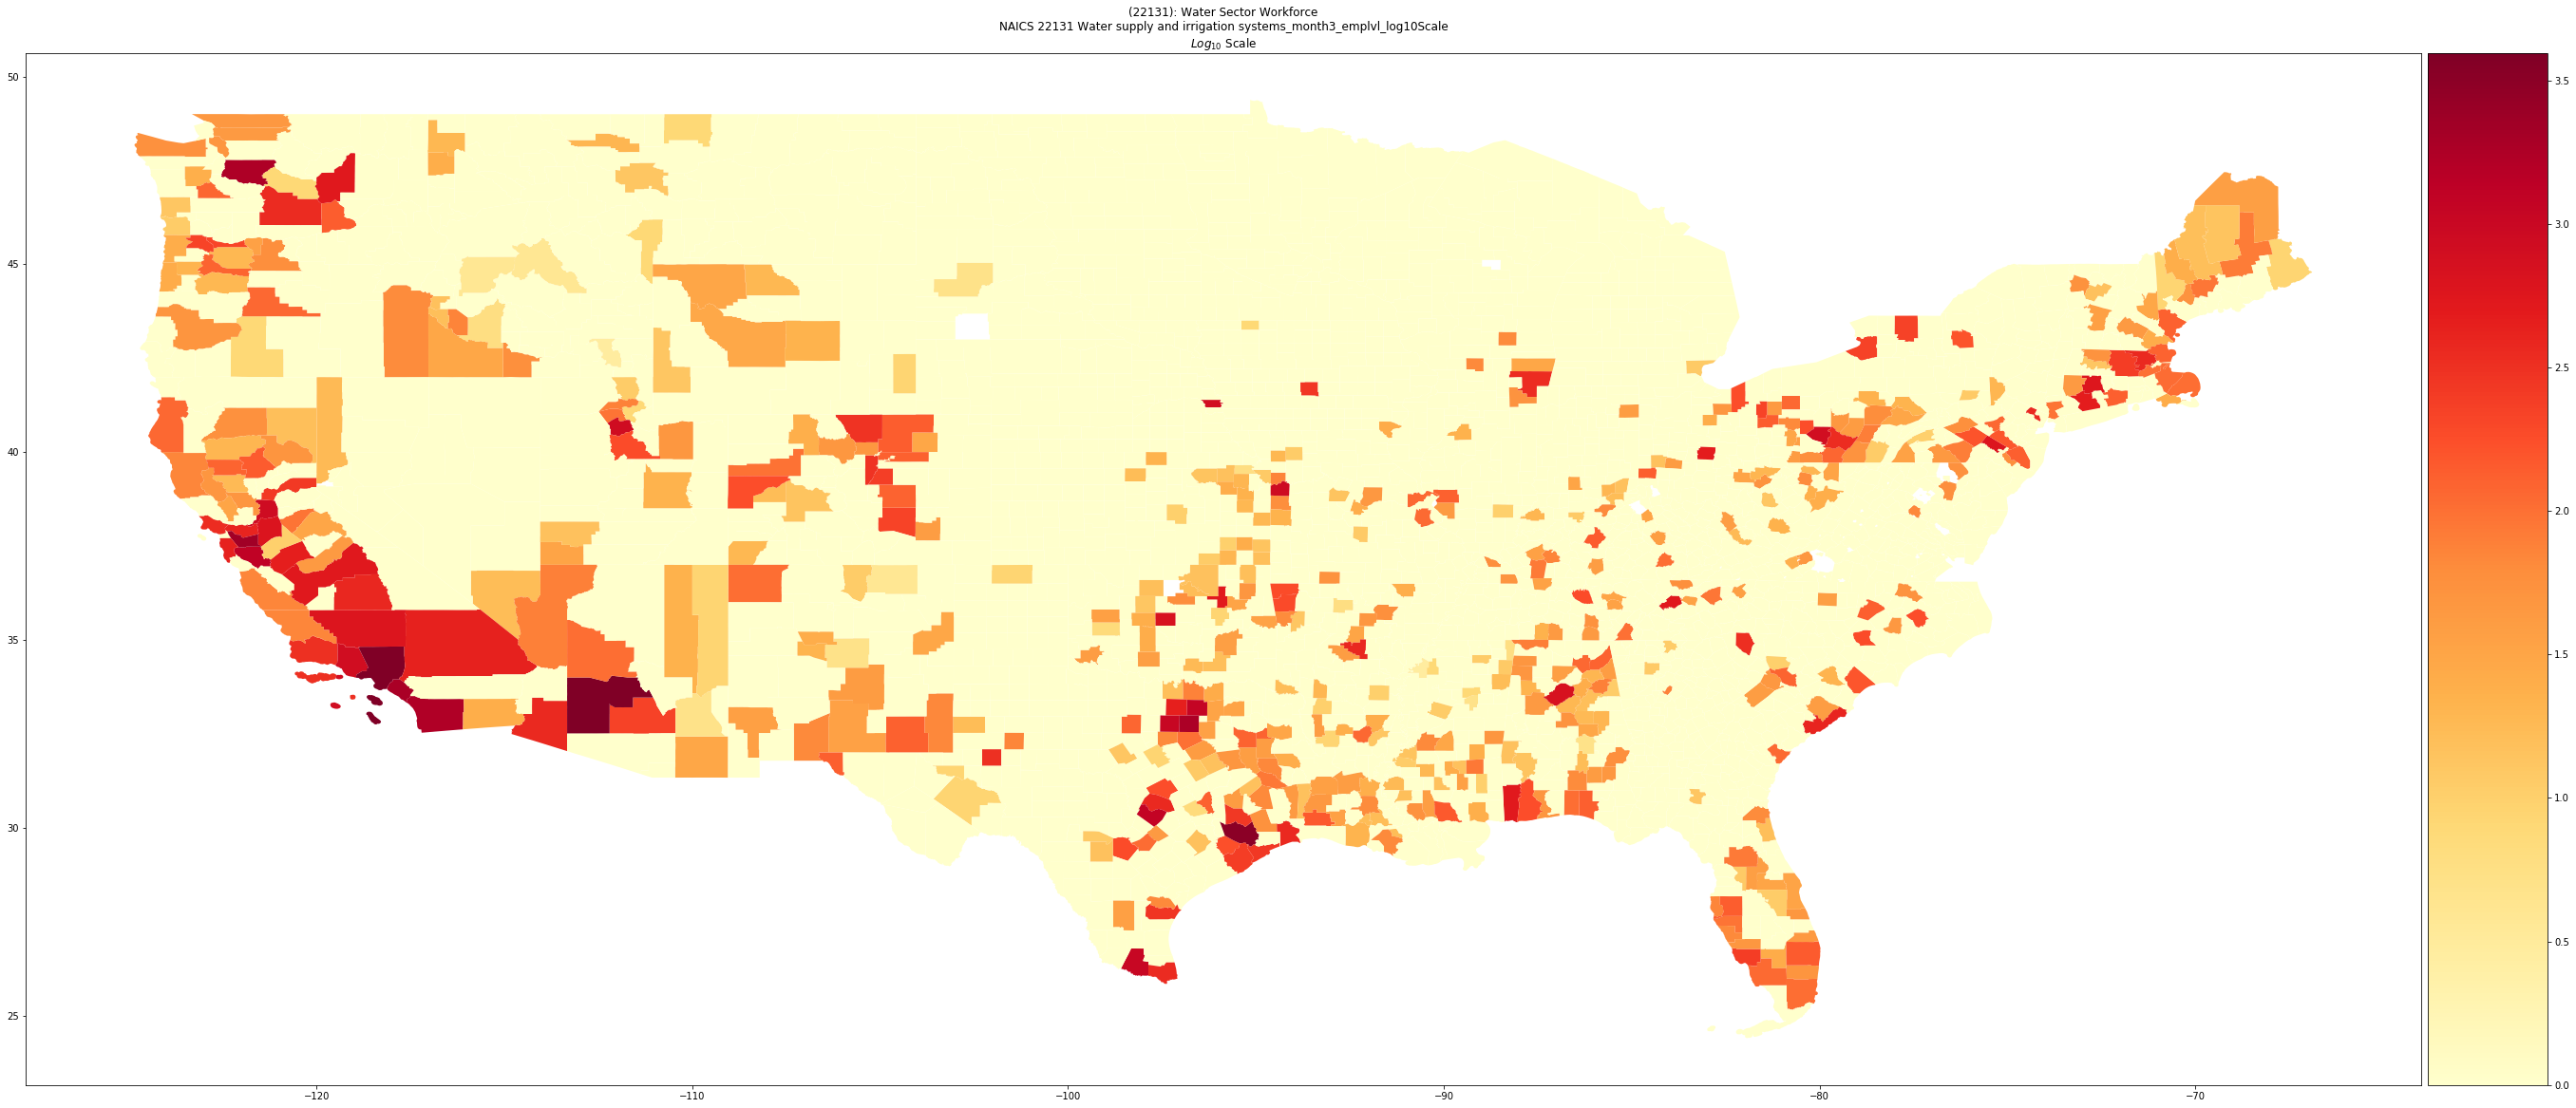

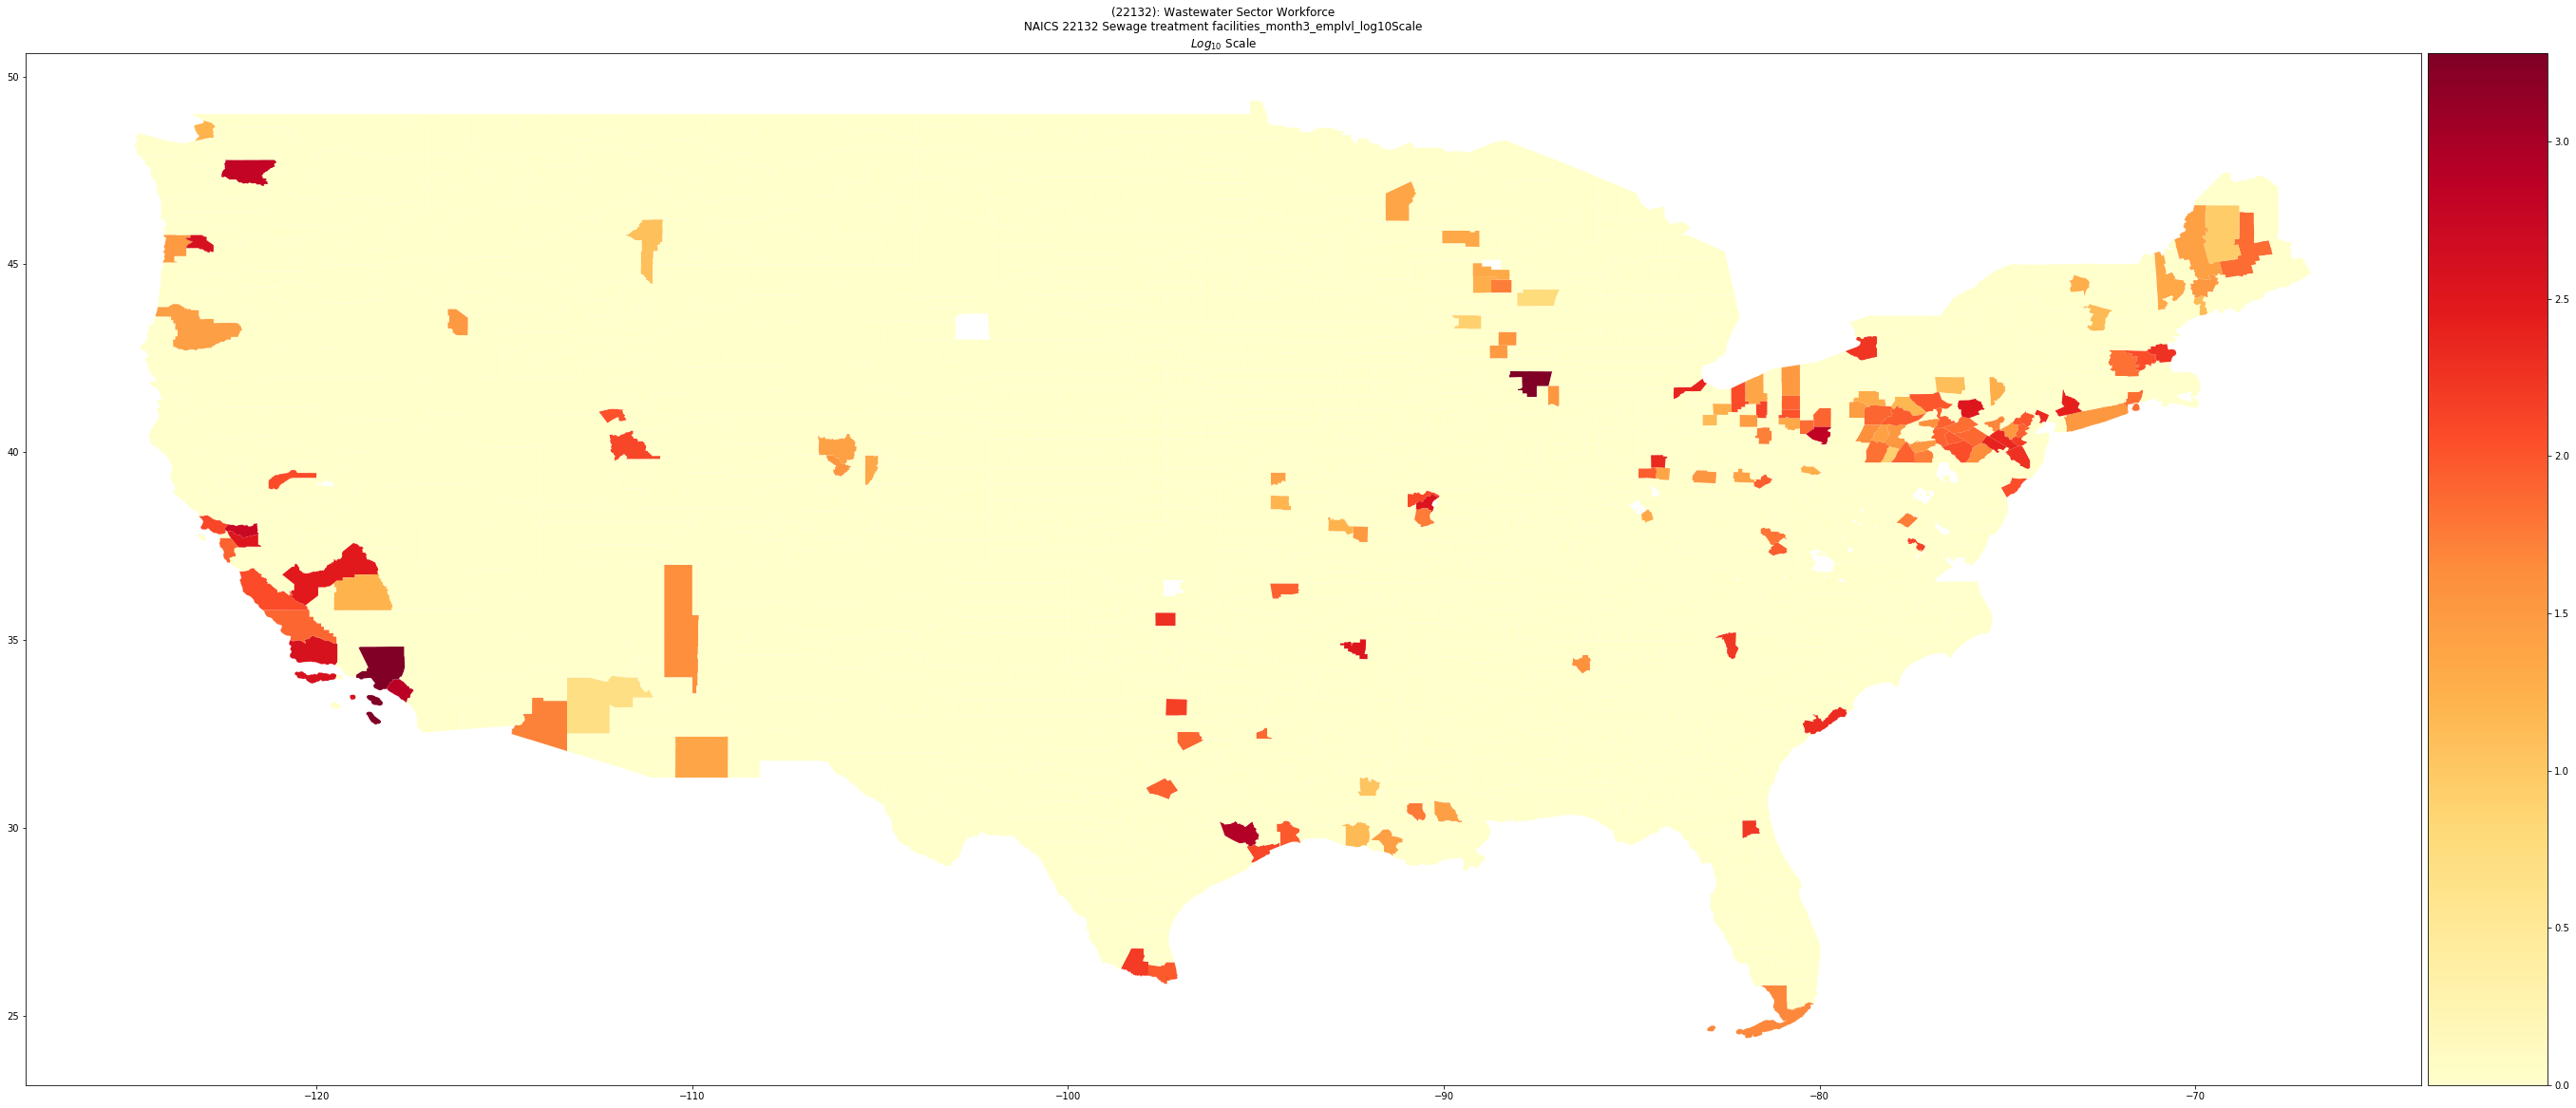

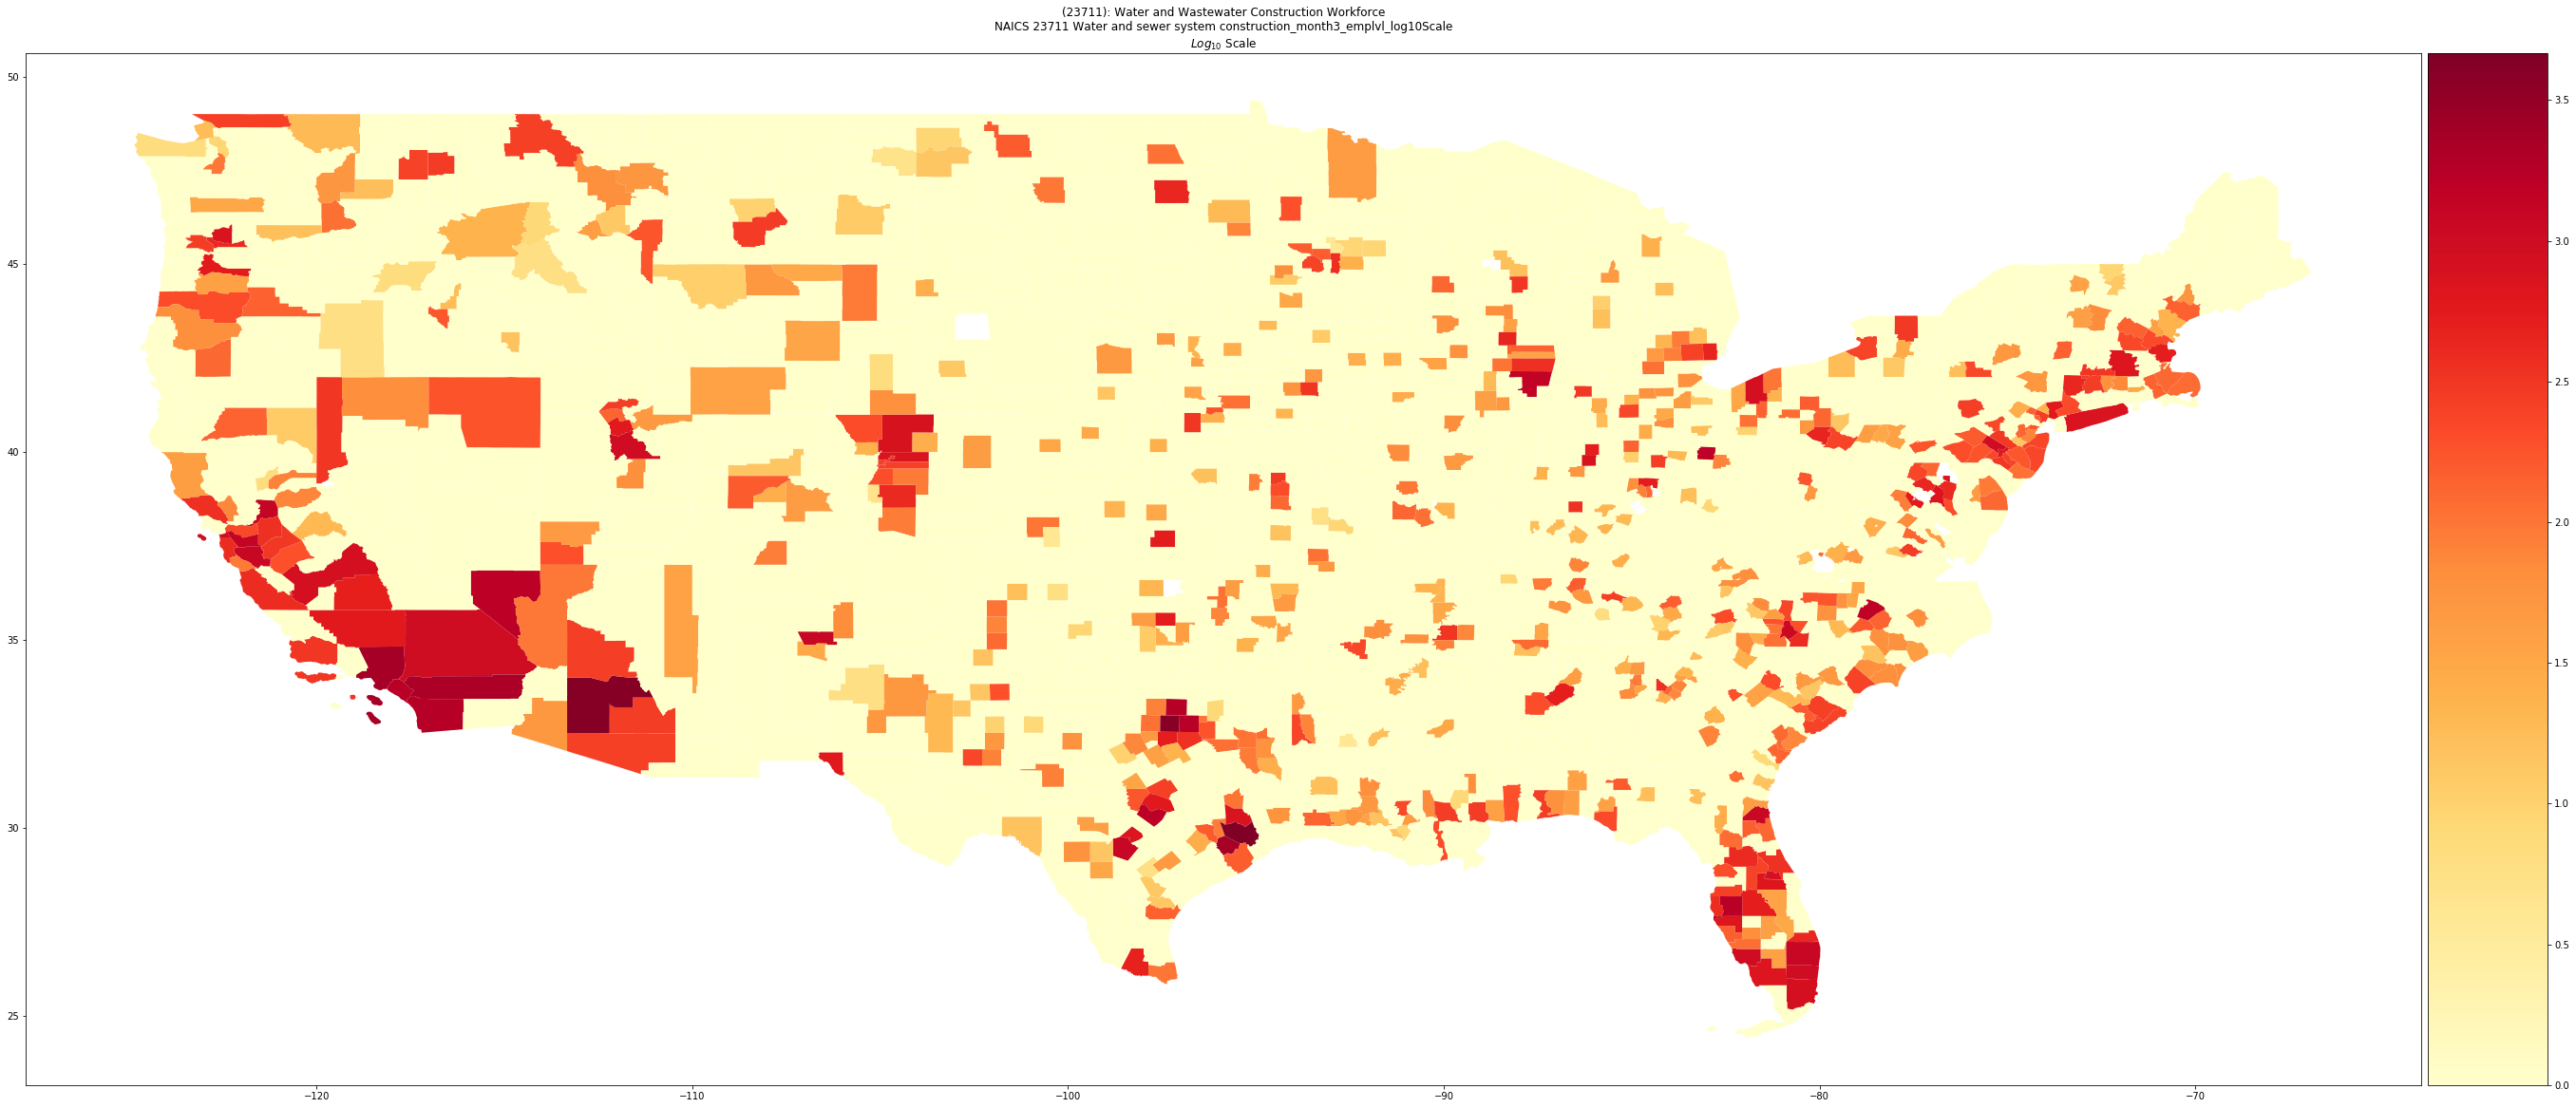

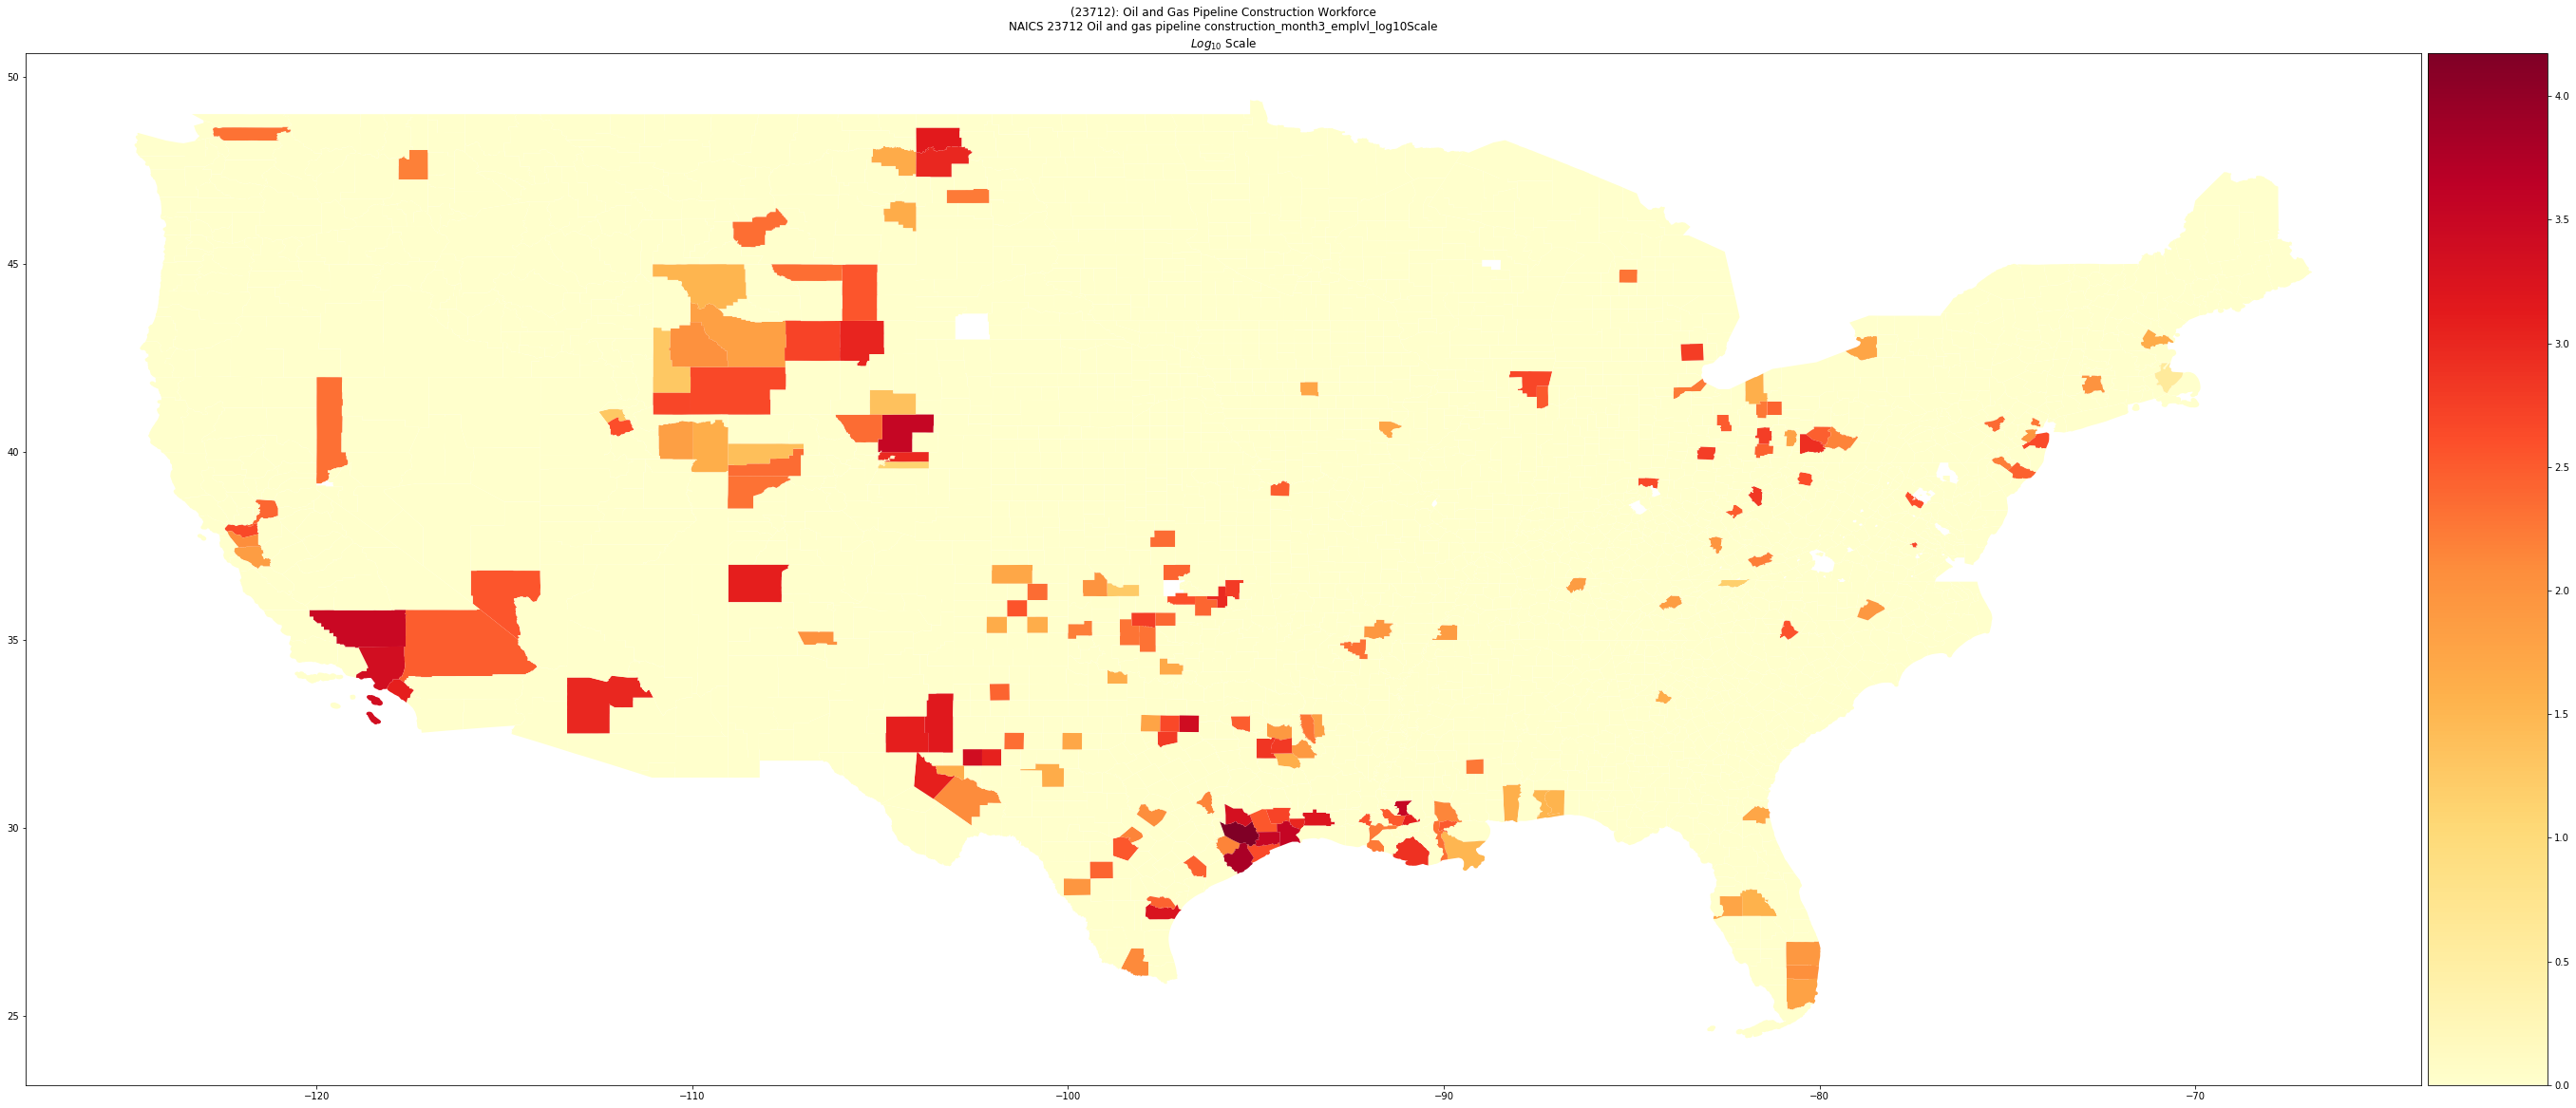

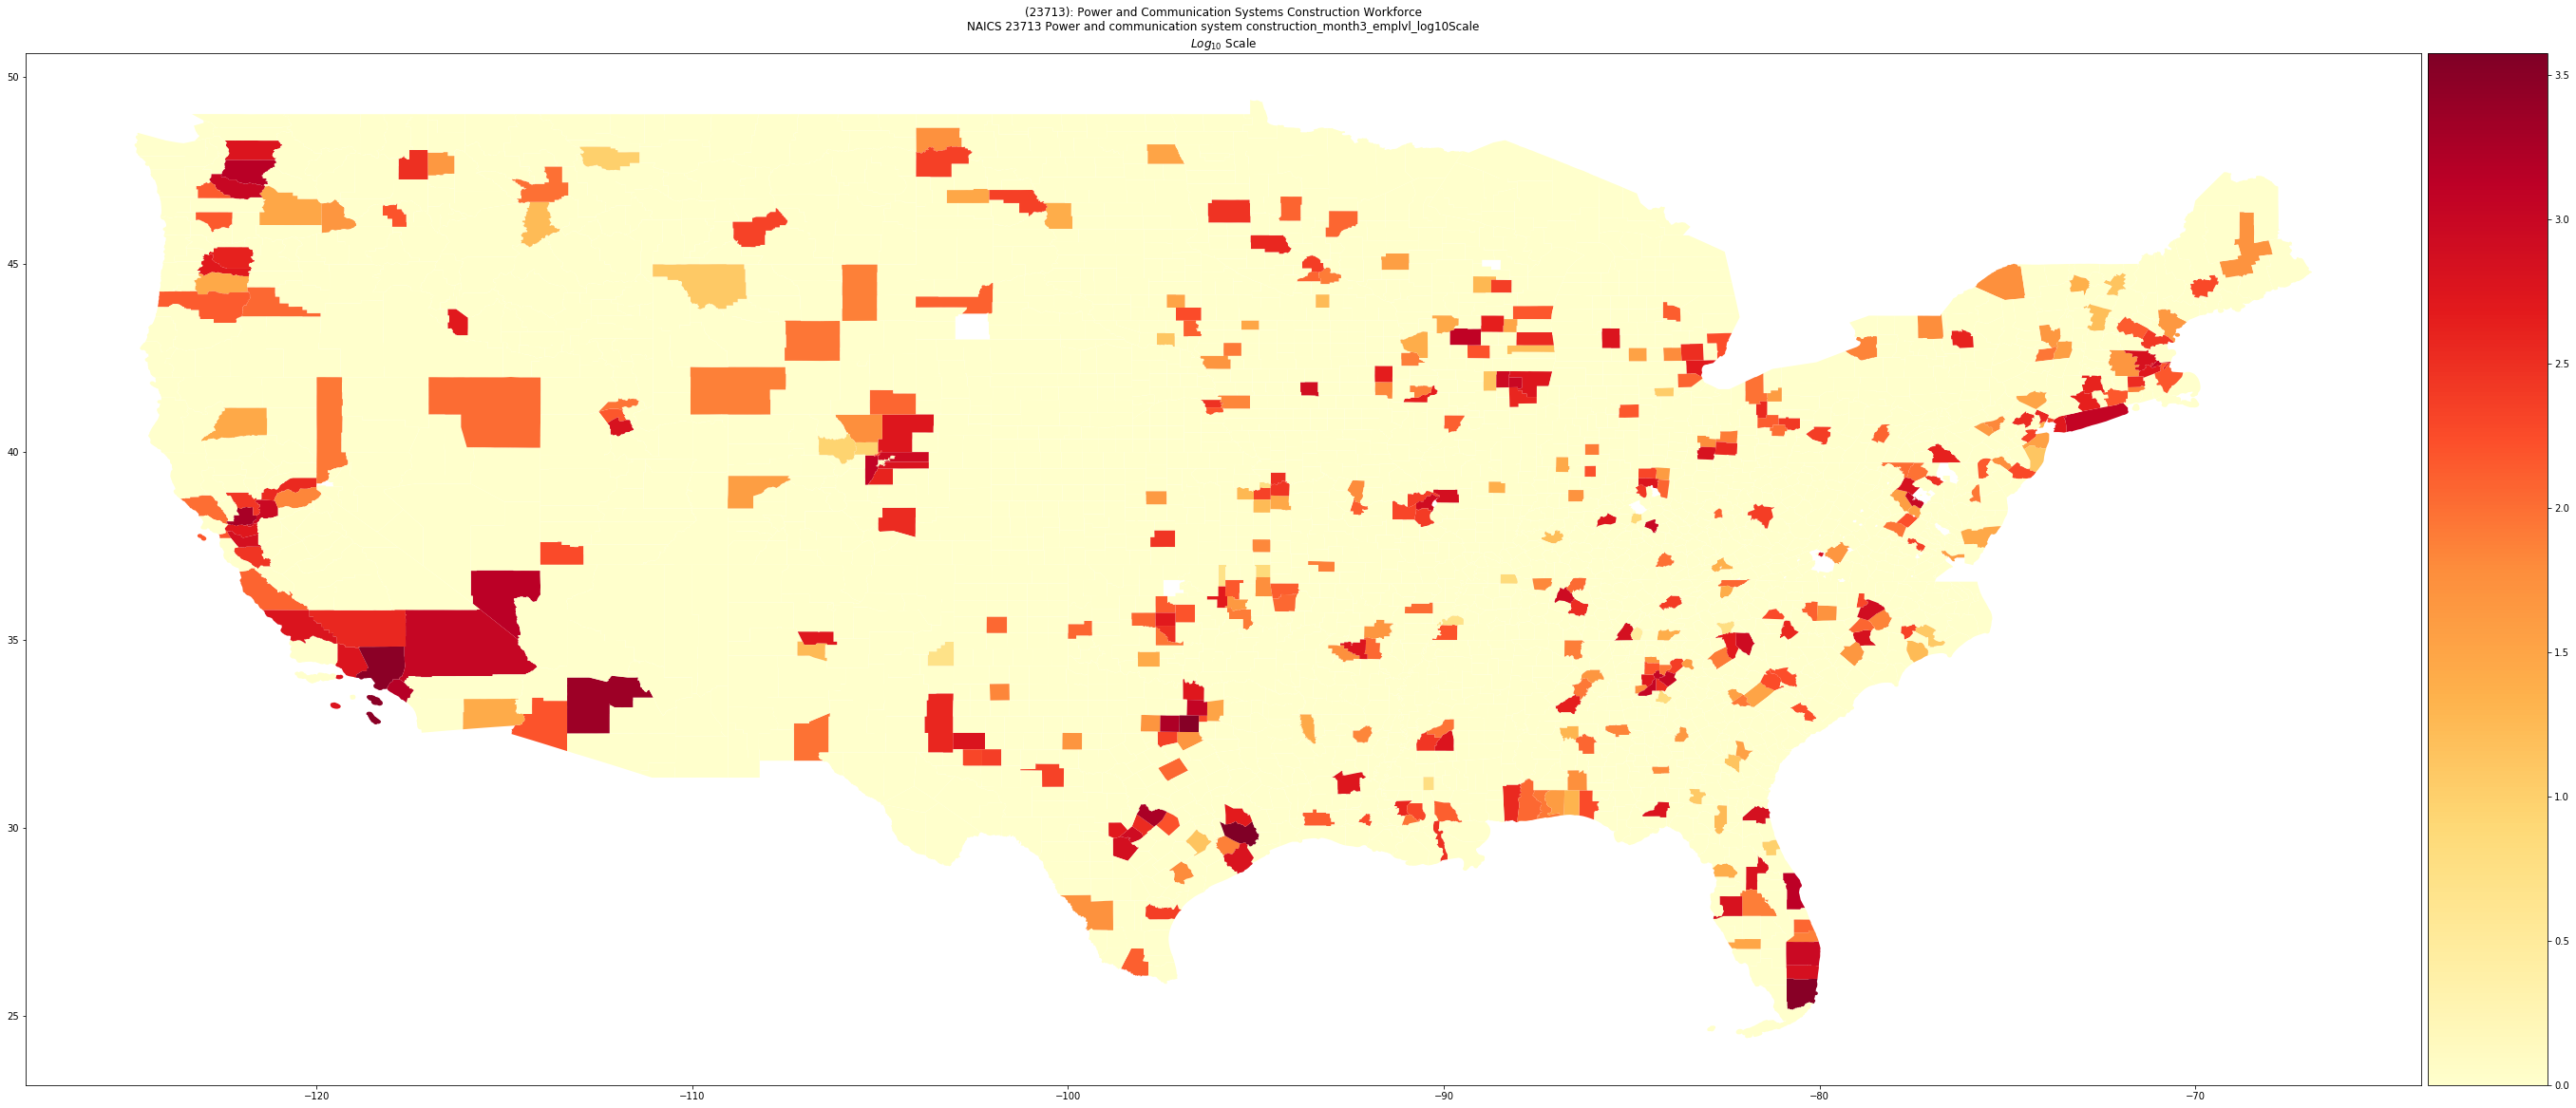

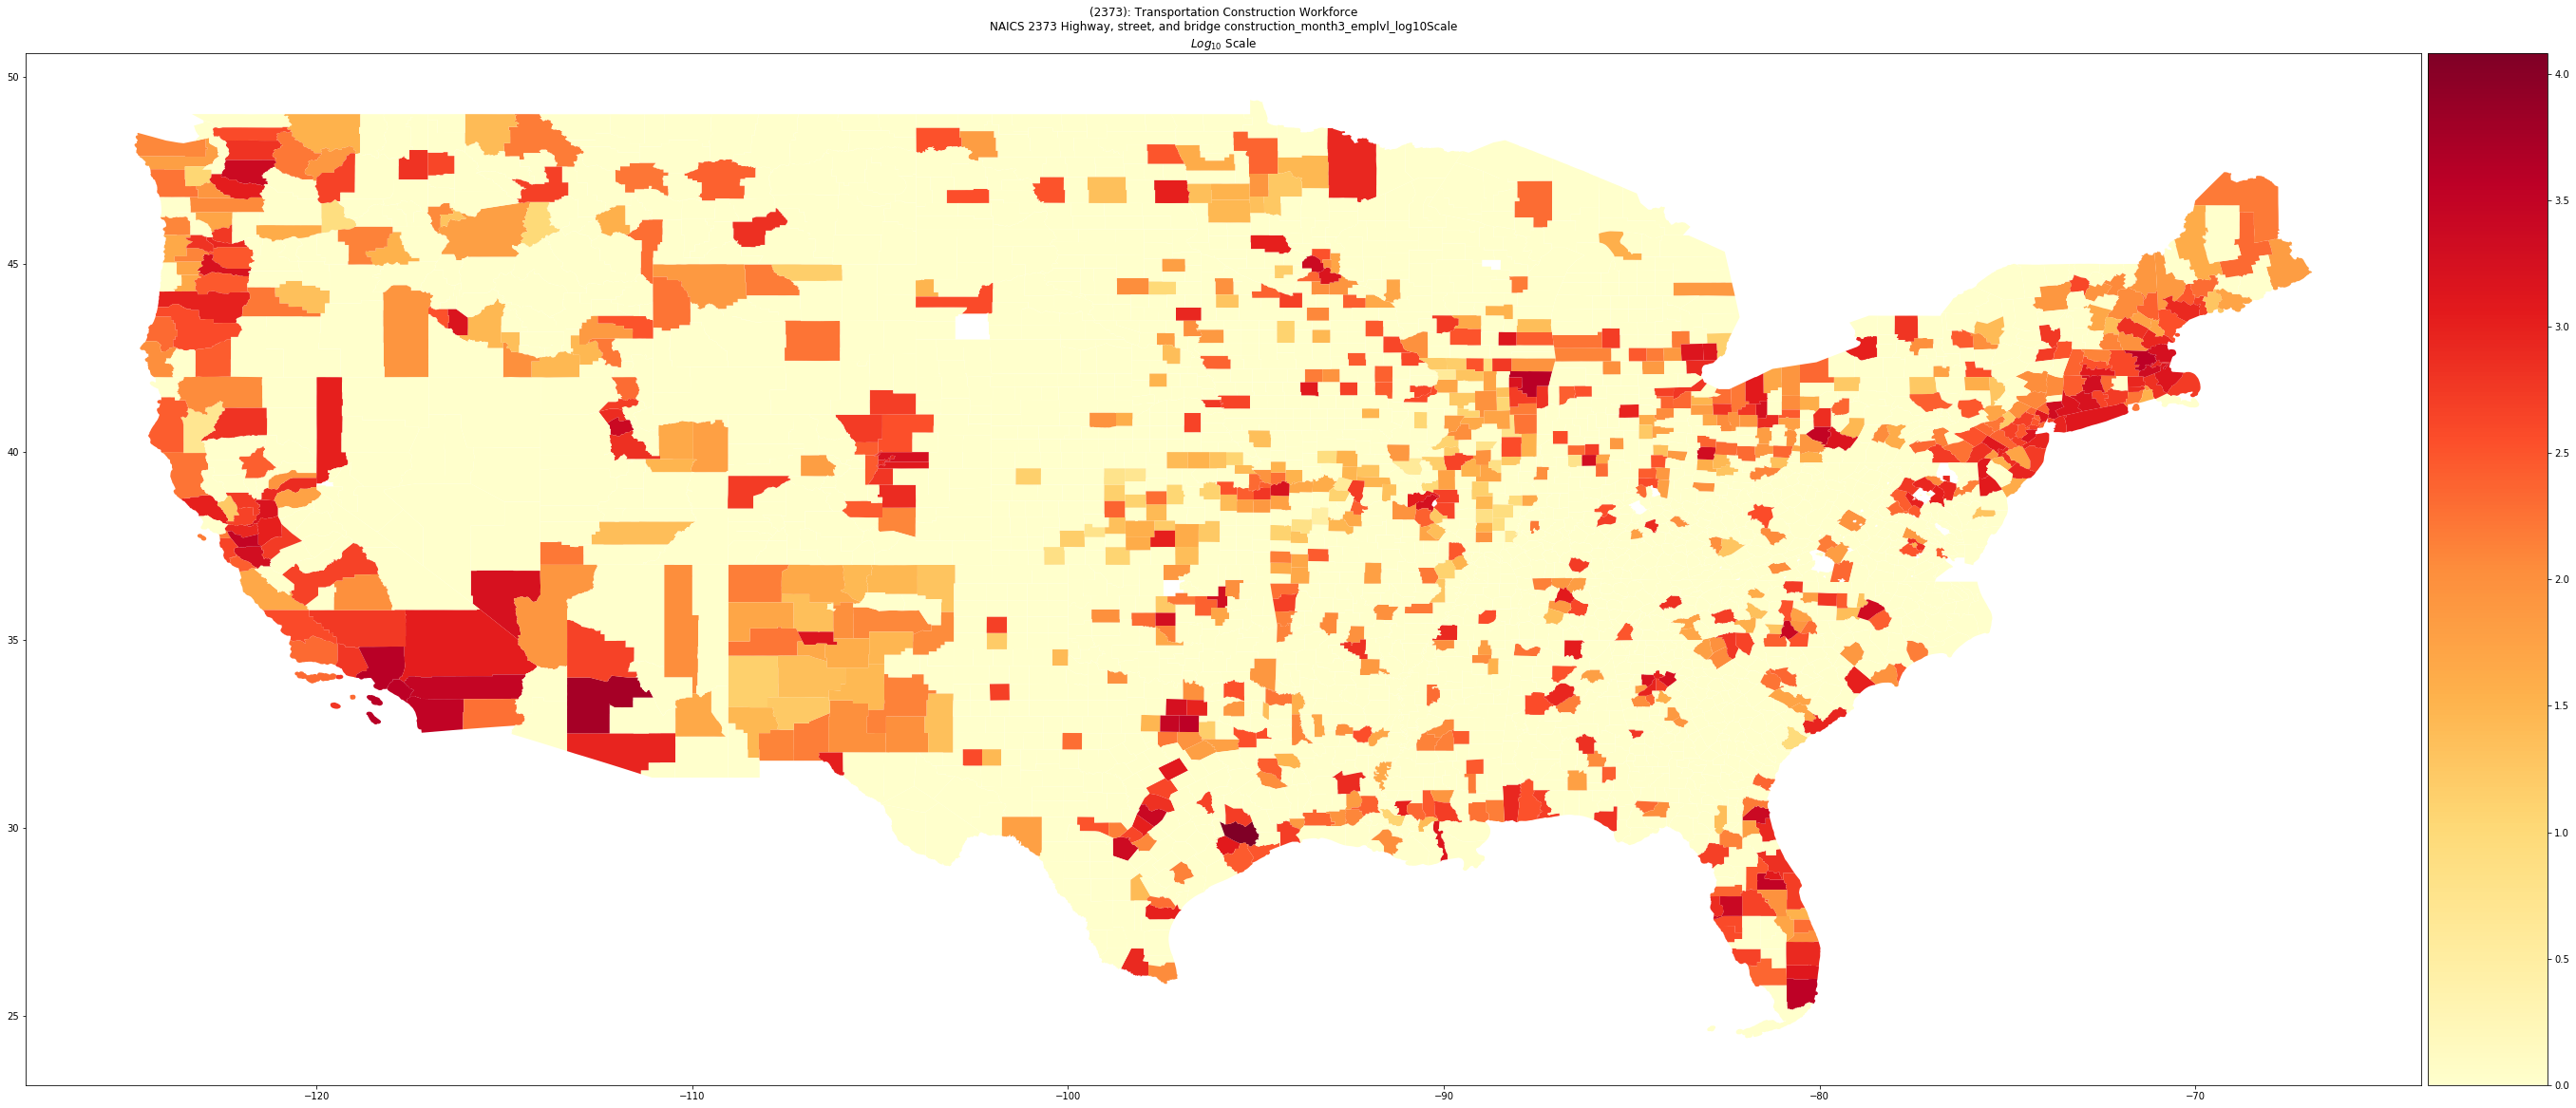

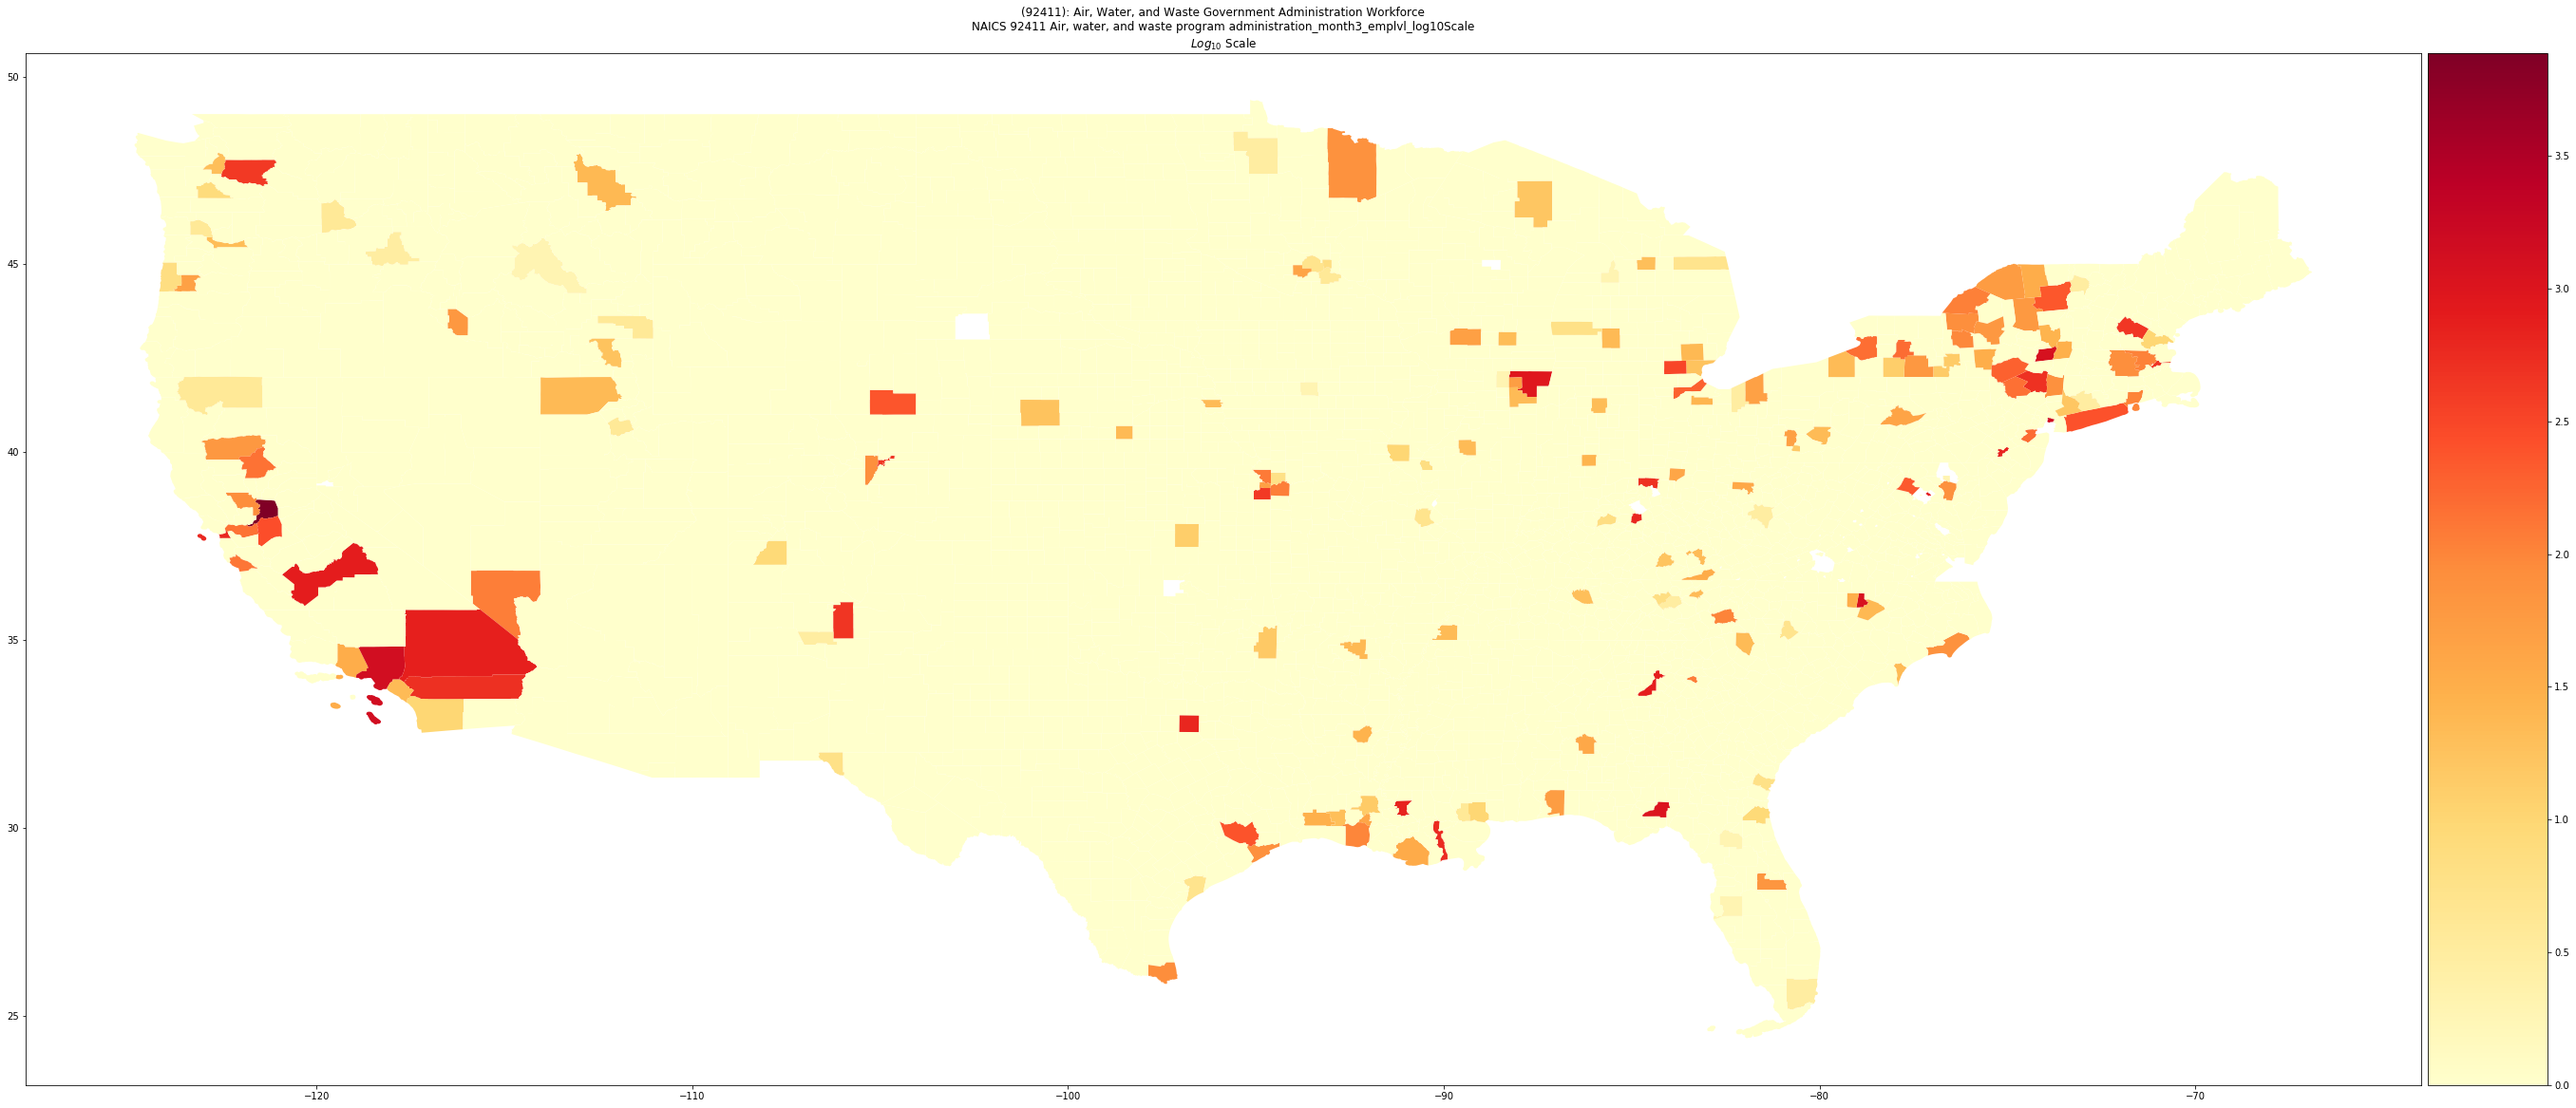

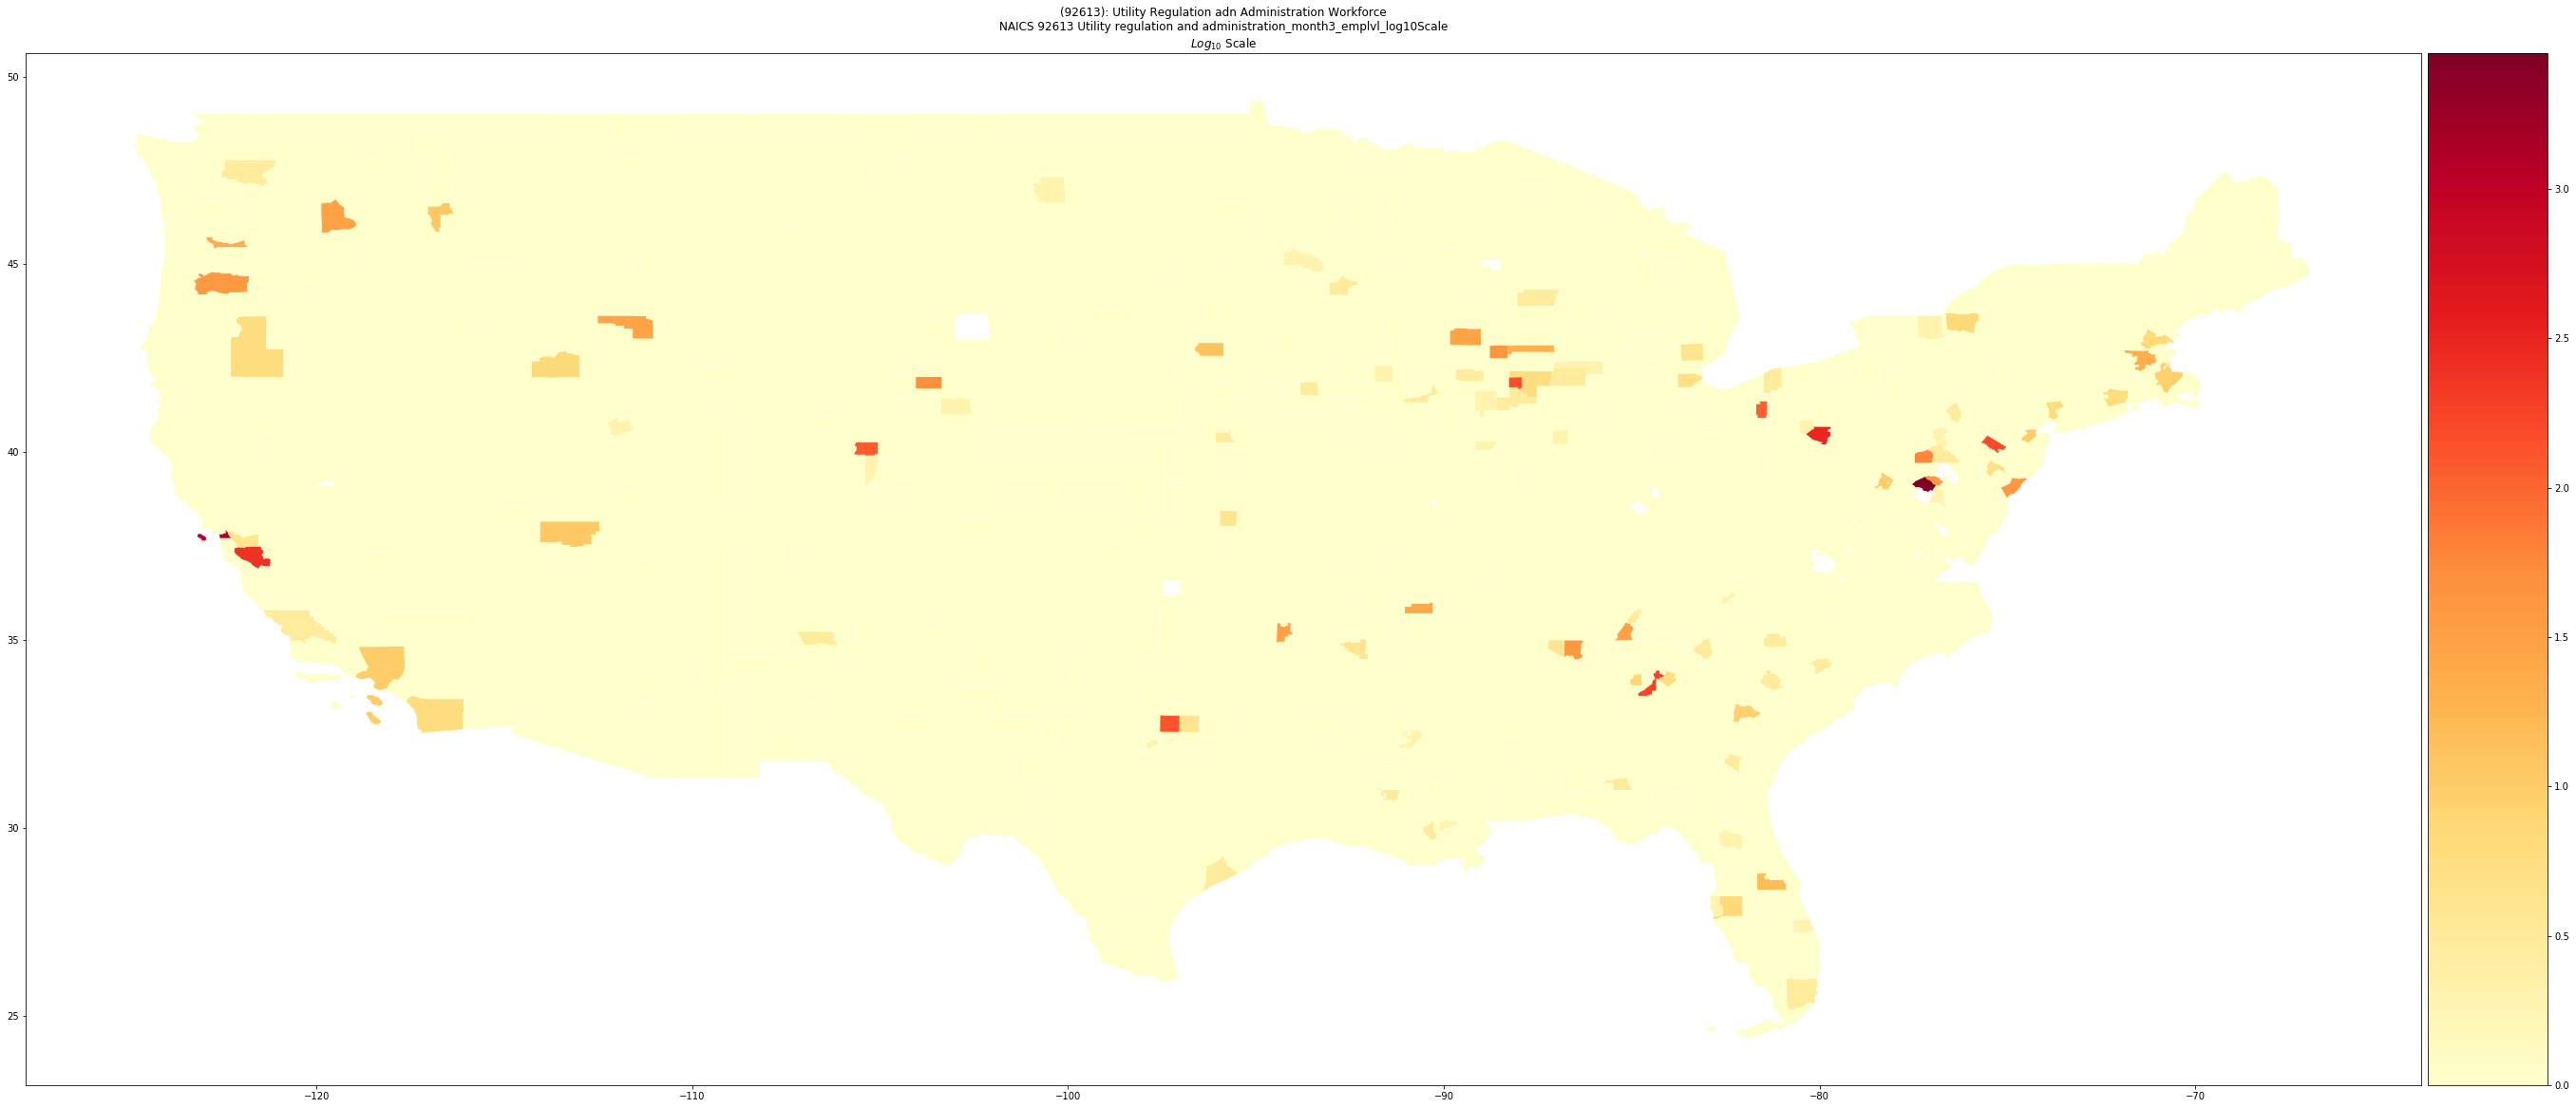

In [498]:
for i,row in df_IndustriesToStartWith.iterrows():
    industry_code = row["industry_code"]
    industry_title = row["industry_title"]
    pretty_name = row["Pretty Name"]
    fig,ax = plt.subplots(figsize=(50,20))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    columnToPlot = f"{industry_title}_{nEmployeesColumn}_log10Scale"
    gdf_USCountyWaterSupplies.cx[-125:-50, 20:70].plot(columnToPlot,
                                                       ax=ax,cax=cax,legend="True",cmap="YlOrRd")
    ax.set_title(f"{pretty_name}\n{columnToPlot}\n$Log_{{10}}$ Scale")

In [445]:
gdf_USCountyWaterSupplies["NAICS 2213 Water, sewage and other systems_month3_emplvl"].sum()

89142.0

In [446]:
gdf_USCountyWaterSupplies[gdf_USCountyWaterSupplies["NAME"] == "Los Angeles"]

STATEFP COUNTYFP  COUNTYNS  GEOID         NAME            NAMELSAD LSAD  \
384      06      037  00277283  06037  Los Angeles  Los Angeles County   06   

    CLASSFP  MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT        ALAND      AWATER  \
384      H1  G4020   348  31080    31084        A  10510588451  1794793532   

        INTPTLAT      INTPTLON  \
384  +34.1963983  -118.2618616   

                                              geometry  \
384  MULTIPOLYGON (((-118.66820 33.48594, -118.6667...   

     PopulationServed Count  PWS ID  County FIPS INT  \
384                10828942     295             6037   

     Base 10 Population Served  \
384                   7.034586   

     NAICS 2211 Power generation and supply_qtrly_estabs  \
384                                              108.0     

     NAICS 2211 Power generation and supply_month3_emplvl  \
384                                             5609.0      

     NAICS 2211 Power generation and supply_lq_month3_emplvl  \
384                                               0.48         

     NAICS 2211 Power generation and supply_qtrly_estabs_log10Scale  \
384                                           2.033424                

     NAICS 2211 Power generation and supply_month3_emplvl_log10Scale  \
384                                           3.748885                 

     NAICS 2211 Power generation and supply_lq_month3_emplvl_log10Scale  \
384                                          -0.318759                    

     County FIPS INT_log10Scale_x  \
384                      3.780821   

     NAICS 2212 Natural gas distribution_qtrly_estabs  \
384                                              66.0   

     NAICS 2212 Natural gas distribution_month3_emplvl  \
384                                                0.0   

     NAICS 2212 Natural gas distribution_lq_month3_emplvl  \
384                                                0.0      

     NAICS 2212 Natural gas distribution_qtrly_estabs_log10Scale  \
384                                           1.819544             

     NAICS 2212 Natural gas distribution_month3_emplvl_log10Scale  \
384                                                0.0              

     NAICS 2212 Natural gas distribution_lq_month3_emplvl_log10Scale  \
384                                                0.0                 

     County FIPS INT_log10Scale_y  \
384                      3.780821   

     NAICS 2213 Water, sewage and other systems_qtrly_estabs  \
384                                              140.0         

     NAICS 2213 Water, sewage and other systems_month3_emplvl  \
384                                             4737.0          

     NAICS 2213 Water, sewage and other systems_lq_month3_emplvl  \
384                                               0.95             

     NAICS 2213 Water, sewage and other systems_qtrly_estabs_log10Scale  \
384                                           2.146128                    

     NAICS 2213 Water, sewage and other systems_month3_emplvl_log10Scale  \
384                                           3.675503                     

     NAICS 2213 Water, sewage and other systems_lq_month3_emplvl_log10Scale  \
384                                          -0.022276                        

     County FIPS INT_log10Scale_x  \
384                      3.780821   

     NAICS 22131 Water supply and irrigation systems_qtrly_estabs  \
384                                              125.0              

     NAICS 22131 Water supply and irrigation systems_month3_emplvl  \
384                                             3946.0               

     NAICS 22131 Water supply and irrigation systems_lq_month3_emplvl  \
384                                               1.65                  

     NAICS 22131 Water supply and irrigation systems_qtrly_estabs_log10Scale  \
384                                            2.09691                         

     NAICS 22131 Water supply and irrigation systems_month3

Calculate utility operators per 1000 population

In [451]:
for i,row in df_IndustriesToStartWith.iterrows():
    industry_code = row["industry_code"]
    industry_title = row["industry_title"]
    columnToCalculate = f"{industry_title}_{nEmployeesColumn}"
    newColumnName = f"{columnToCalculate}_Per1000"
    gdf_USCountyWaterSupplies[newColumnName] = gdf_USCountyWaterSupplies[columnToCalculate] / gdf_USCountyWaterSupplies["PopulationServed Count"] * 1000

Realize Florida is county is low because of remarkably low population.  As a kludge lets eliminate and replace with a lower "high" number of 10

In [501]:
df_IndustriesToStartWith

industry_code                                     industry_title Include  \
199           2211             NAICS 2211 Power generation and supply     Yes   
213           2212                NAICS 2212 Natural gas distribution     Yes   
216           2213         NAICS 2213 Water, sewage and other systems     Yes   
217          22131    NAICS 22131 Water supply and irrigation systems     Yes   
219          22132            NAICS 22132 Sewage treatment facilities     Yes   
238          23711    NAICS 23711 Water and sewer system construction     Yes   
240          23712      NAICS 23712 Oil and gas pipeline construction     Yes   
242          23713  NAICS 23713 Power and communication system con...     Yes   
247           2373  NAICS 2373 Highway, street, and bridge constru...     Yes   
2460         92411  NAICS 92411 Air, water, and waste program admi...     Yes   
2476         92613  NAICS 92613 Utility regulation and administration     Yes   

     High Level Include                                        Pretty Name  
199                 Yes      (2211): Power Generation and Supply Workforce  
213                 Yes          (2212): Natural Gas Distribution Workorce  
216                 Yes     (2213): Overall Water and Wastewater Workforce  
217                 Yes                    (22131): Water Sector Workforce  
219                 Yes               (22132): Wastewater Sector Workforce  
238                 Yes  (23711): Water and Wastewater Construction Wor...  
240                 Yes  (23712): Oil and Gas Pipeline Construction Wor...  
242                 Yes  (23713): Power and Communication Systems Const...  
247                 Yes      (2373): Transportation Construction Workforce  
2460                Yes  (92411): Air, Water, and Waste Government Admi...  
2476                Yes  (92613): Utility Regulation adn Administration...

In [507]:
industry_title = "NAICS 22132 Sewage treatment facilities"
columnToUpdate = f"{industry_title}_{nEmployeesColumn}_Per1000"
gdf_USCountyWaterSupplies[gdf_USCountyWaterSupplies[columnToUpdate]>100][columnToUpdate].index[0]

1340

In [508]:
gdf_USCountyWaterSupplies.at[gdf_USCountyWaterSupplies[gdf_USCountyWaterSupplies[columnToUpdate]>100][columnToUpdate].index[0],columnToUpdate] = 10

AttributeError: 'BlockManager' object has no attribute 'T'

In [511]:
list(gdf_USCountyWaterSupplies.columns)

['STATEFP',
 'COUNTYFP',
 'COUNTYNS',
 'GEOID',
 'NAME',
 'NAMELSAD',
 'LSAD',
 'CLASSFP',
 'MTFCC',
 'CSAFP',
 'CBSAFP',
 'METDIVFP',
 'FUNCSTAT',
 'ALAND',
 'AWATER',
 'INTPTLAT',
 'INTPTLON',
 'geometry',
 'PopulationServed Count',
 'PWS ID',
 'County FIPS INT',
 'Base 10 Population Served',
 'NAICS 2211 Power generation and supply_qtrly_estabs',
 'NAICS 2211 Power generation and supply_month3_emplvl',
 'NAICS 2211 Power generation and supply_lq_month3_emplvl',
 'NAICS 2211 Power generation and supply_qtrly_estabs_log10Scale',
 'NAICS 2211 Power generation and supply_month3_emplvl_log10Scale',
 'NAICS 2211 Power generation and supply_lq_month3_emplvl_log10Scale',
 'County FIPS INT_log10Scale_x',
 'NAICS 2212 Natural gas distribution_qtrly_estabs',
 'NAICS 2212 Natural gas distribution_month3_emplvl',
 'NAICS 2212 Natural gas distribution_lq_month3_emplvl',
 'NAICS 2212 Natural gas distribution_qtrly_estabs_log10Scale',
 'NAICS 2212 Natural gas distribution_month3_emplvl_log10Scale',

In [510]:
for i,row in df_IndustriesToStartWith.iterrows():
    industry_code = row["industry_code"]
    industry_title = row["industry_title"]
    pretty_name = row["Pretty Name"]
    fig,ax = plt.subplots(figsize=(50,20))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    columnToPlot = f"{industry_title}_{nEmployeesColumn}_Per1000"
    gdf_USCountyWaterSupplies.cx[-125:-50, 20:70].plot(columnToPlot,
                                                       ax=ax,cax=cax,legend="True",cmap="YlOrRd")
    installationAreas.cx[-125:-50, 20:70].boundary.plot(ax=ax,color=None, edgecolor='black',label="US Army Installation") # https://gis.stackexchange.com/questions/299379/superposing-two-plots-with-geopandas-with-non-fill-colours-in-one-of-them
    ax.set_title(f"{pretty_name}\n{columnToPlot}\nPer 1000 Water Served")

SyntaxError: invalid syntax (<ipython-input-510-fd2a7cd5953d>, line 3)

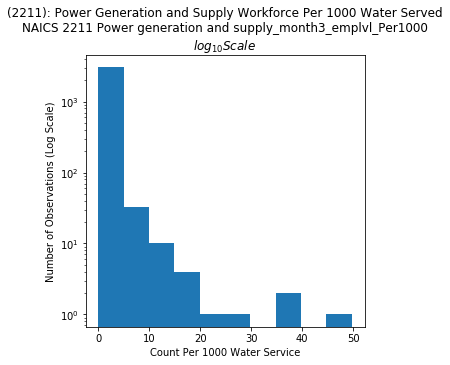

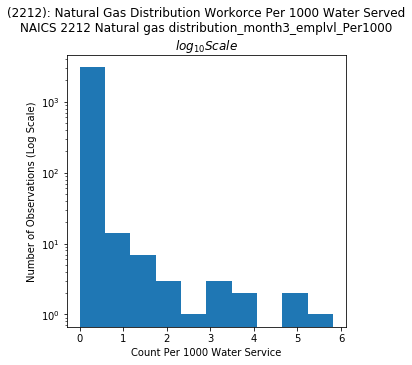

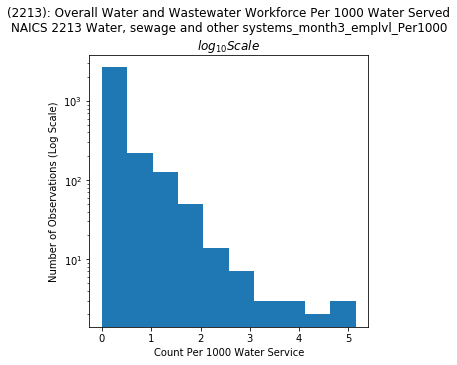

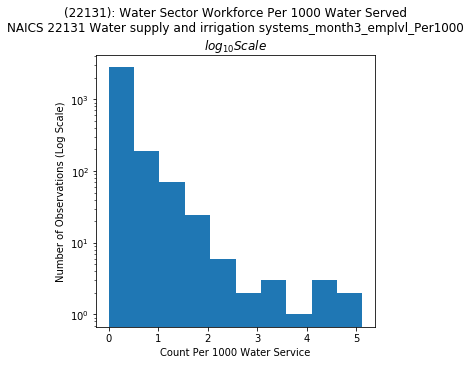

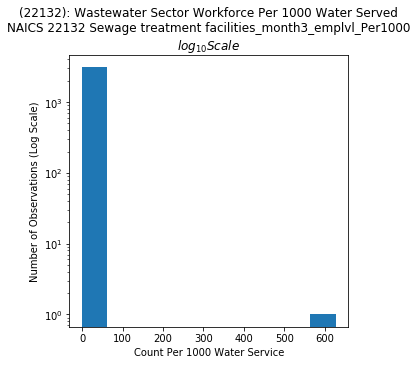

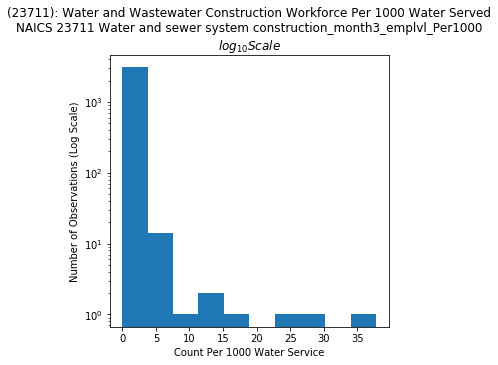

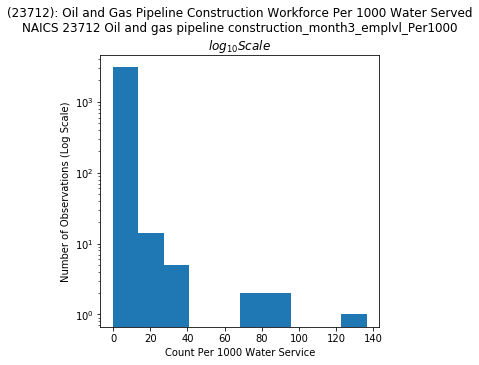

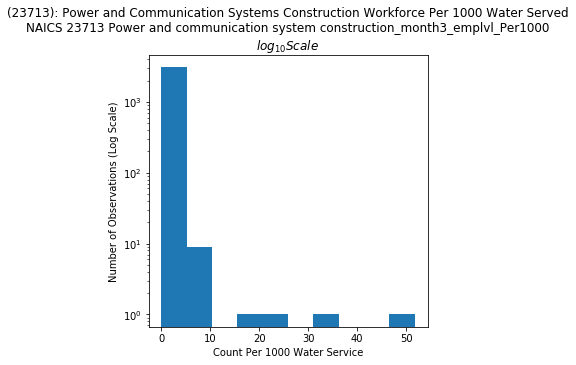

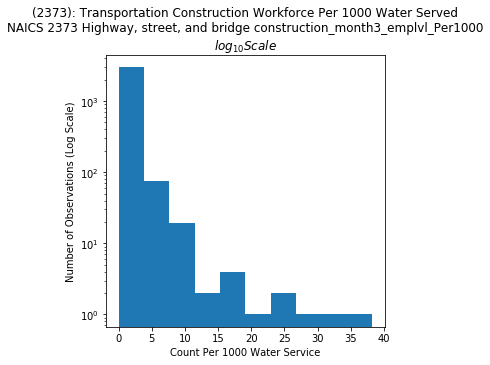

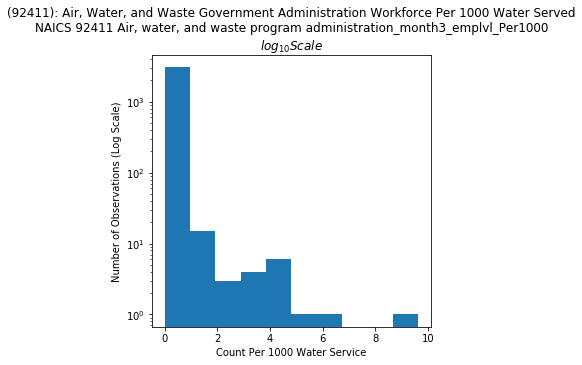

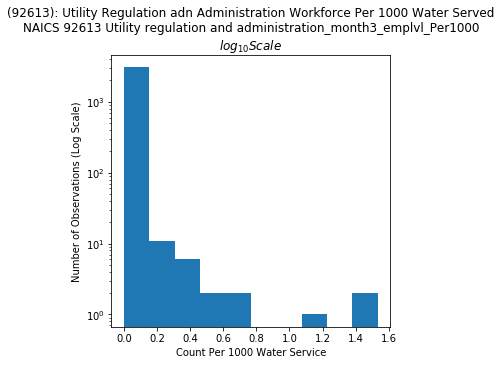

In [500]:
for i,row in df_IndustriesToStartWith.iterrows():
    industry_code = row["industry_code"]
    industry_title = row["industry_title"]
    pretty_name = row["Pretty Name"]
    fig,ax = plt.subplots(figsize=(5,5))
    columnToPlot = f"{industry_title}_{nEmployeesColumn}_Per1000"
    ax.hist(gdf_USCountyWaterSupplies[columnToPlot])
    ax.set_yscale("log")
    ax.set_title(f"{pretty_name} Per 1000 Water Served\n{columnToPlot}\n$log_{{10}} Scale$")
    ax.set_ylabel("Number of Observations (Log Scale)")
    ax.set_xlabel("Count Per 1000 Water Service")